In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_center_scale_100_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_100_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_center_scale_100_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 12:51:23 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:51:23 pyobsbox.generator INFO: shuffle: True
Feb/23 12:51:23 pyobsbox.generator INFO: seed: 42
Feb/23 12:51:23 pyobsbox.generator INFO: batch_size: 8192
Feb/23 12:51:23 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 12:51:23 pyobsbox.generator INFO: n_bunches: 256
Feb/23 12:51:23 pyobsbox.generator INFO: __len__: 1046
Feb/23 12:51:23 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 12:51:23 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 12:51:23 pyobsbox.generator INFO: normalization: center_scale
Feb/23 12:51:23 pyobsbox.generator INFO: normalization_pre_split: False
Feb/23 12:51:23 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 100}
Feb/23 12:51:23 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 12:51:23 pyobsbox.

In [9]:
print(train_metadata.shape)
train_metadata.head()

(267776, 11)


type  fill  beam plane  q           date_time  \
7245919  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889305  Inst  7453     1     h  7 2018-11-18 06:39:21   
1617564  Inst  6663     1     h  7 2018-05-10 15:13:15   
6142130  Inst  6953     1     h  7 2018-07-21 06:32:07   
593890   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245919  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889305  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/...        480   
1617564  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6142130  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593890   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245919        140.0          84.0      65536  
6889305        879.0         163.0      65536  
1617564       1578.0        1153.0      65536  
6142130        494.0         348.0      65536  
593890        2722.0        1497.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
4070565  Inst  6245     1     h  7 2017-09-27 00:11:14   
9702665  Inst  6617     1     h  7 2018-04-27 14:54:14   
3104256  Inst  7483     1     h  7 2018-11-29 06:50:15   
4569504  Inst  7024     1     h  7 2018-08-05 07:42:13   
7539671  Inst  7365     1     h  7 2018-10-27 00:13:27   

                                                      file  n_bunches  \
4070565  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   
9702665  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6617/...        263   
3104256  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/...        648   
4569504  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7024/...        636   
7539671  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7365/...        852   

         bunch_index  bunch_number  ts_length  
4070565       3342.0        1851.0      65536  
9702665        228.0          64.0      65536  
3104256       1010.0         185.0      65536  
4569504        721.0         530.0      65536  
7539671        153.0          40.0      65536

# Loss functions

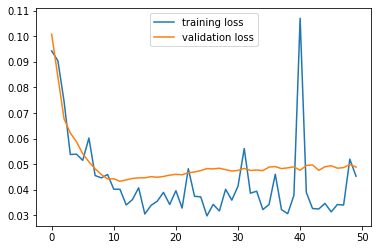

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 50s 999ms/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 946ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

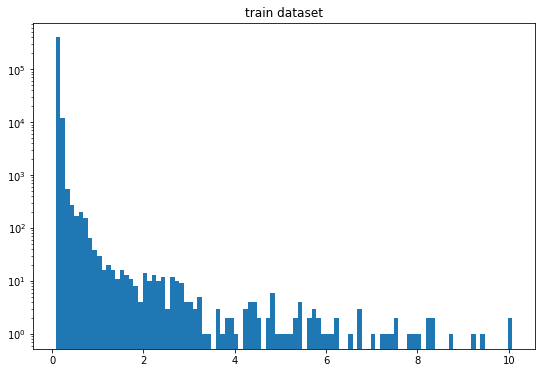

In [38]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.08234366737087839

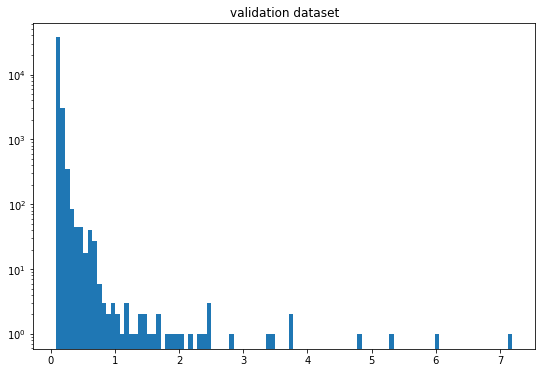

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.08234366737087839

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([392349,  87715,  61151, ..., 167365,  90167, 296131])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  392349
MAE:  10.079799641700664
n_bunches        601
bunch_index     1130
bunch_number     394
Name: 7734305, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6621/instability_data/06621_Inst_B1H_Q7_20180429_04h20m45s.h5


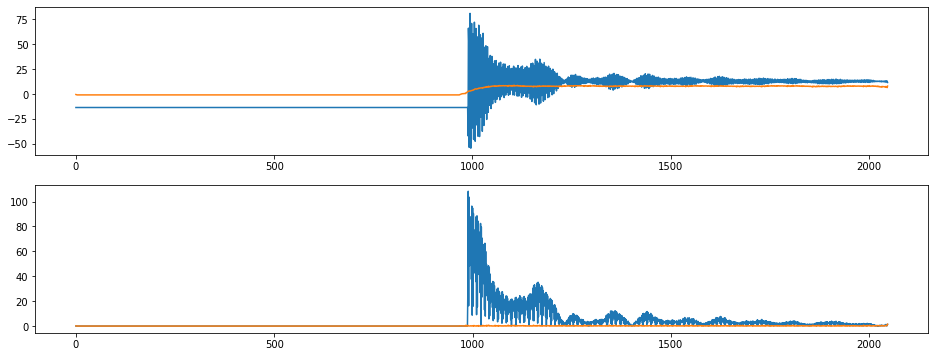

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  392349
MAE:  10.079799641700664
n_bunches        601
bunch_index     1130
bunch_number     394
Name: 7734305, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6621/instability_data/06621_Inst_B1H_Q7_20180429_04h20m45s.h5


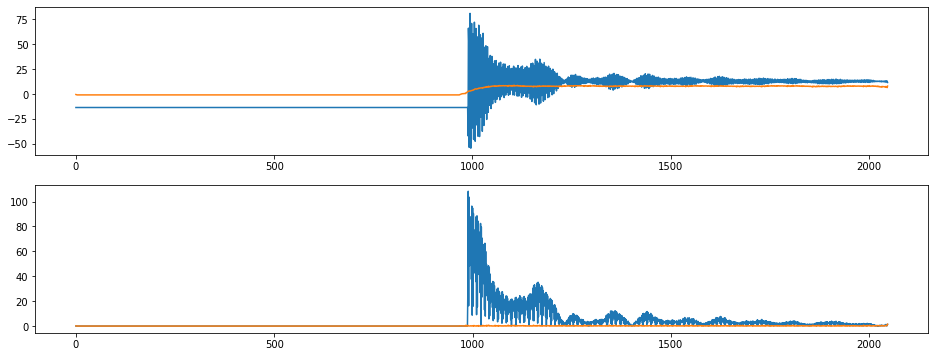

index:  87715
MAE:  10.004691808894714
n_bunches       1916
bunch_index     1206
bunch_number     664
Name: 1484472, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170930_00h40m33s.h5


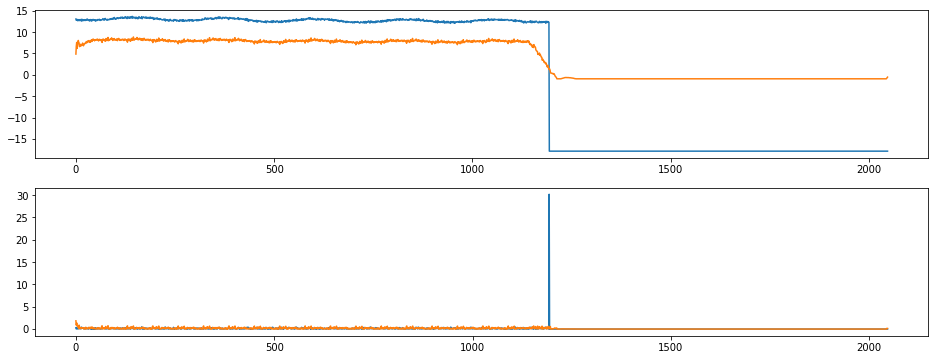

index:  61151
MAE:  9.445473176105516
n_bunches        925
bunch_index     1279
bunch_number     896
Name: 680018, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/instability_data/06639_Inst_B1H_Q7_20180503_15h37m43s.h5


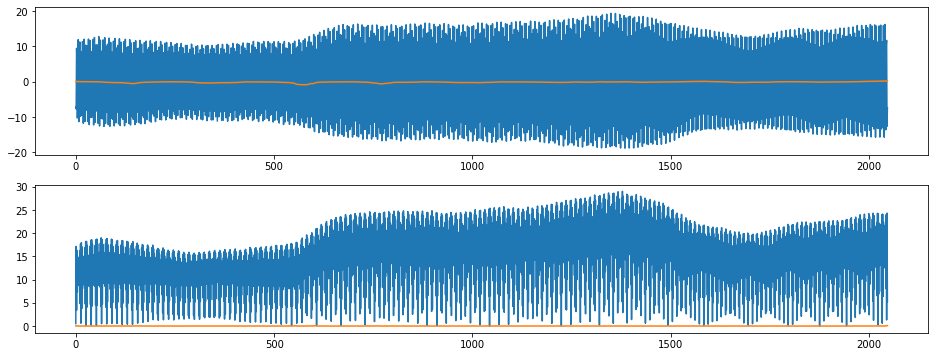

index:  171080
MAE:  9.197050944915393
n_bunches        555
bunch_index     3034
bunch_number     524
Name: 6836335, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6613/instability_data/06613_Inst_B1H_Q7_20180426_00h40m14s.h5


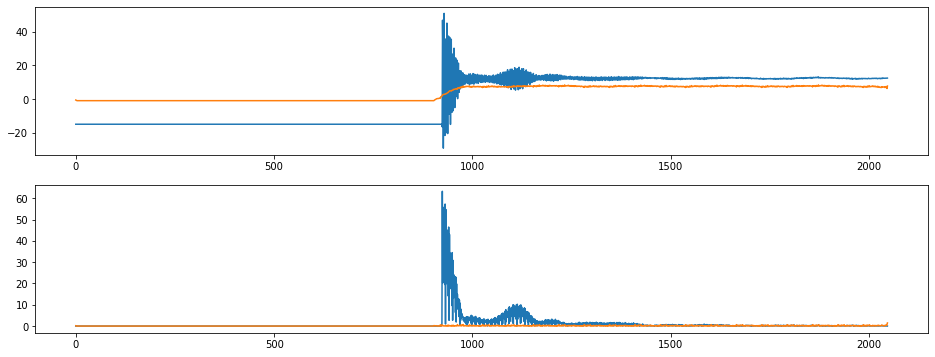

index:  297327
MAE:  8.770161165793542
n_bunches       924
bunch_index     838
bunch_number    605
Name: 9328767, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7105/instability_data/07105_Inst_B1H_Q7_20180830_10h44m14s.h5


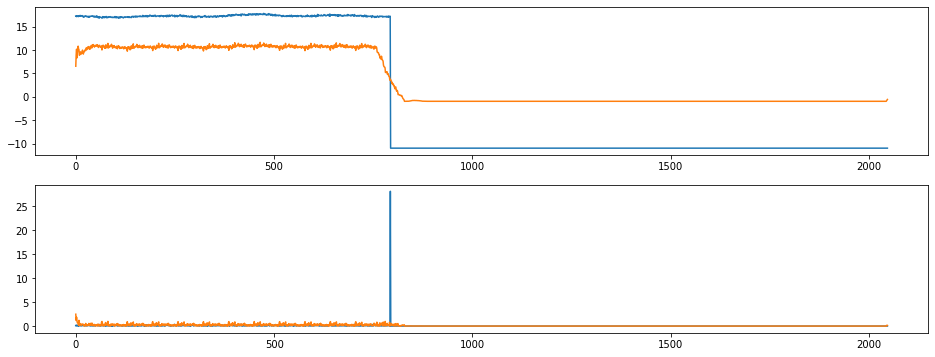

index:  64561
MAE:  8.34769789102189
n_bunches       601
bunch_index     150
bunch_number     26
Name: 3021057, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6621/instability_data/06621_Inst_B1H_Q7_20180429_04h21m24s.h5


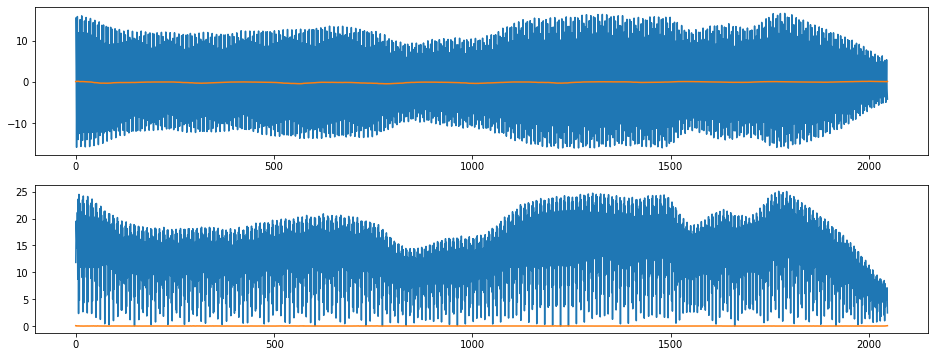

index:  227411
MAE:  8.281024380889718
n_bunches       1212
bunch_index      438
bunch_number     287
Name: 1500493, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h03m11s.h5


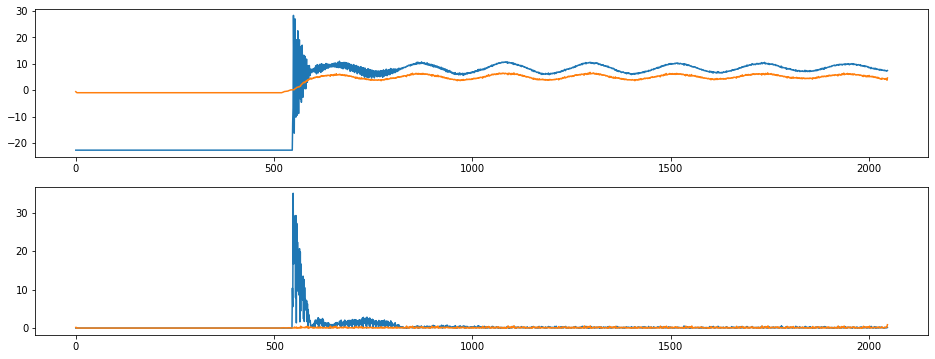

index:  3132
MAE:  8.264206866761233
n_bunches       1452
bunch_index     3334
bunch_number    1416
Name: 9695536, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6892/instability_data/06892_Inst_B1H_Q7_20180707_06h50m14s.h5


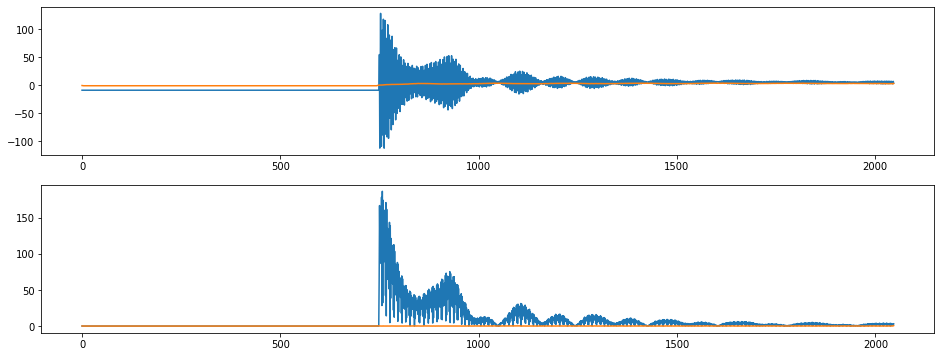

index:  59241
MAE:  8.213684031656374
n_bunches       187
bunch_index     869
bunch_number    182
Name: 10065426, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7492/instability_data/07492_Inst_B1H_Q7_20181202_15h05m04s.h5


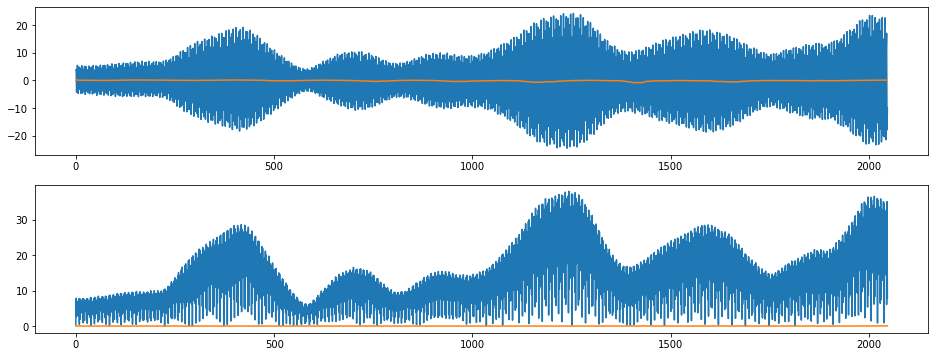

index:  344543
MAE:  8.027058870686595
n_bunches       396
bunch_index     315
bunch_number    214
Name: 6228588, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h09m54s.h5


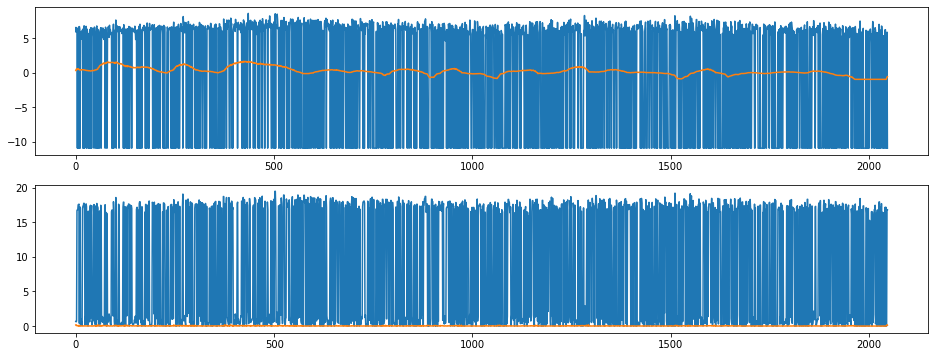

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  296131
MAE:  0.08234366737087839
n_bunches       1452
bunch_index      938
bunch_number     389
Name: 7879837, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_15h41m14s.h5


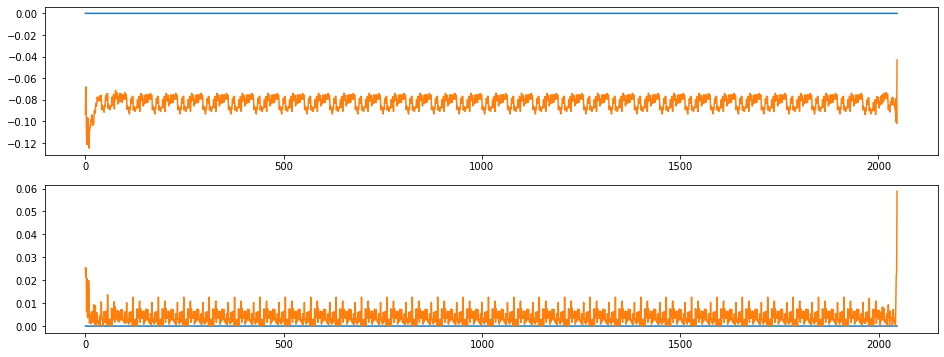

index:  90167
MAE:  0.08234366737087839
n_bunches       1308
bunch_index     1616
bunch_number    1274
Name: 588051, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_17h58m14s.h5


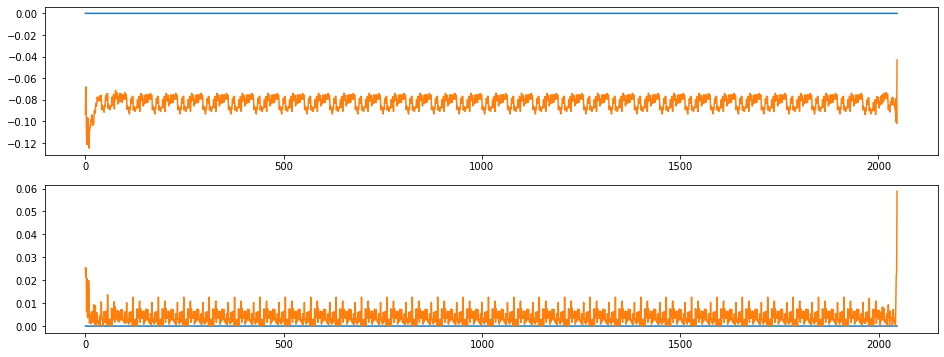

index:  167365
MAE:  0.08234366737087839
n_bunches       1868
bunch_index      703
bunch_number     381
Name: 5864864, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_23h39m14s.h5


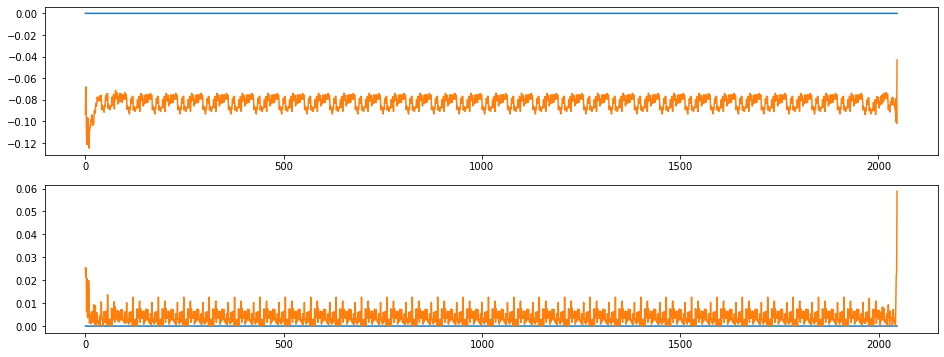

index:  324359
MAE:  0.08234366737087839
n_bunches       925
bunch_index     386
bunch_number    272
Name: 2632973, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/instability_data/06639_Inst_B1H_Q7_20180503_15h38m11s.h5


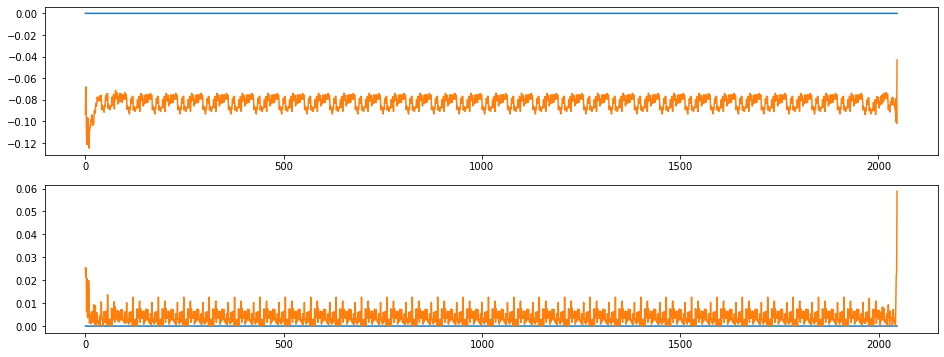

index:  121333
MAE:  0.08234366737087839
n_bunches       133
bunch_index     510
bunch_number     95
Name: 2424679, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6982/instability_data/06982_Inst_B1H_Q7_20180726_18h17m13s.h5


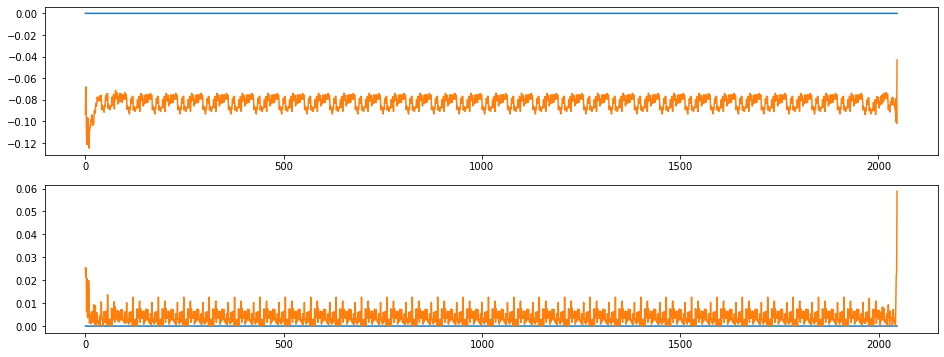

index:  81818
MAE:  0.08234366737087839
n_bunches       1812
bunch_index     1738
bunch_number     890
Name: 5113555, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_04h49m02s.h5


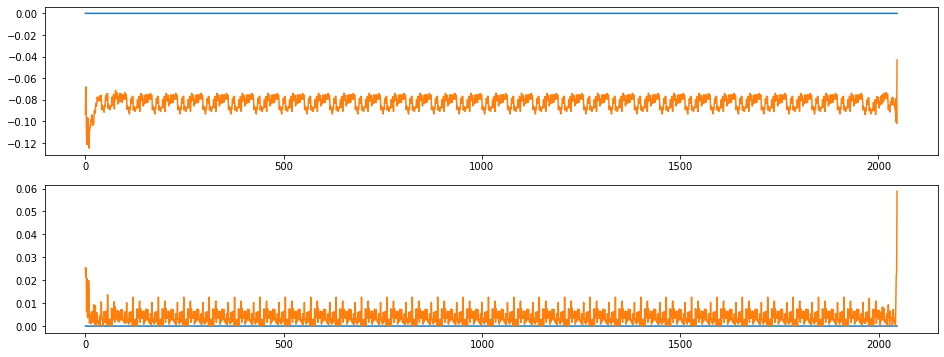

index:  19207
MAE:  0.08234366737087839
n_bunches       1916
bunch_index     1230
bunch_number     680
Name: 11356614, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_16h15m15s.h5


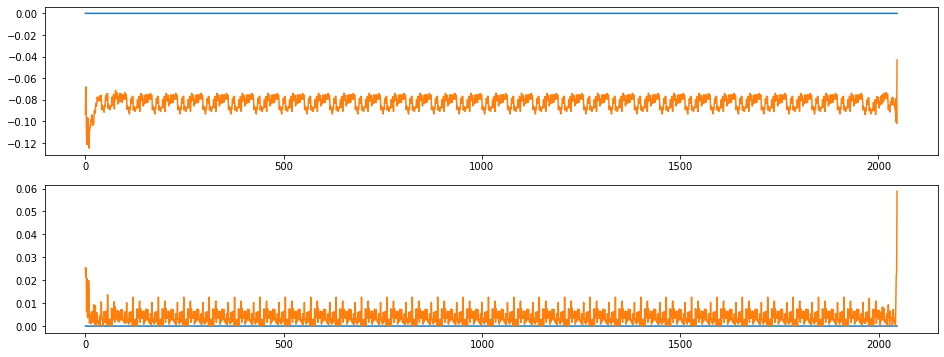

index:  96584
MAE:  0.08234366737087839
n_bunches       12
bunch_index     21
bunch_number     3
Name: 9699041, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6922/instability_data/06922_Inst_B1H_Q7_20180714_18h32m35s.h5


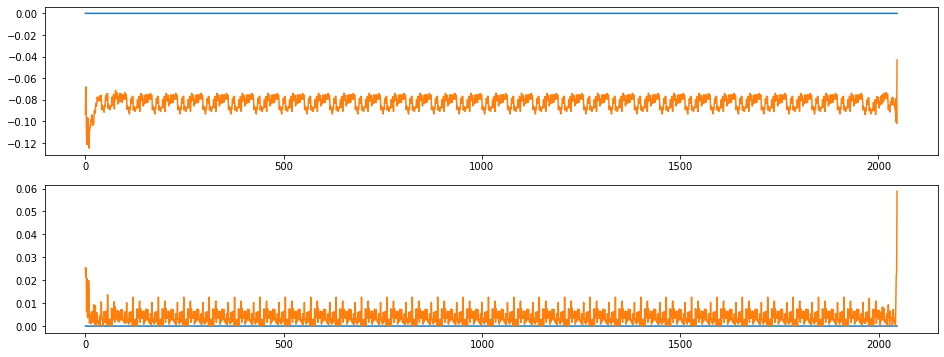

index:  111276
MAE:  0.08234366737087839
n_bunches       780
bunch_index     401
bunch_number    269
Name: 2032226, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7040/instability_data/07040_Inst_B1H_Q7_20180809_19h14m16s.h5


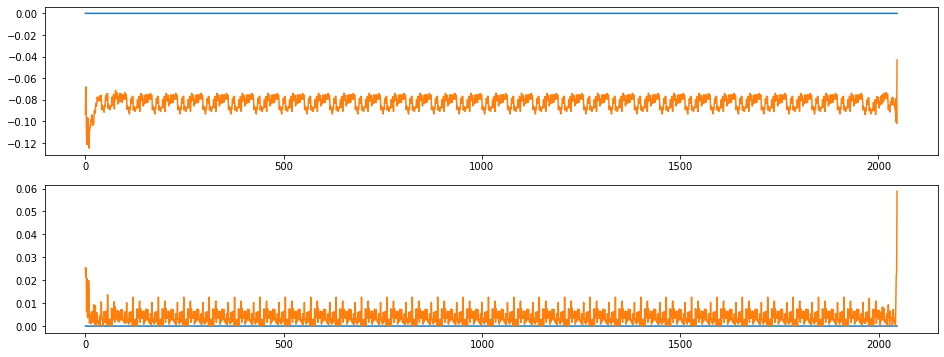

index:  136517
MAE:  0.08234366737087839
n_bunches       1836
bunch_index     1607
bunch_number     858
Name: 4198778, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_17h07m14s.h5


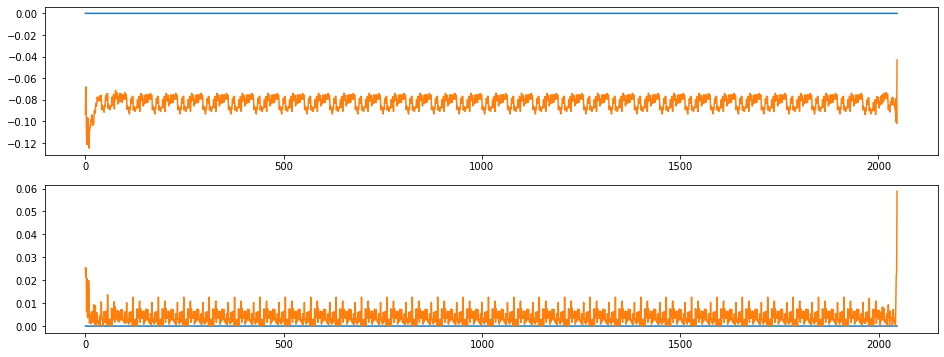

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  296131
MAE:  0.08234366737087839
n_bunches       1452
bunch_index      938
bunch_number     389
Name: 7879837, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_15h41m14s.h5


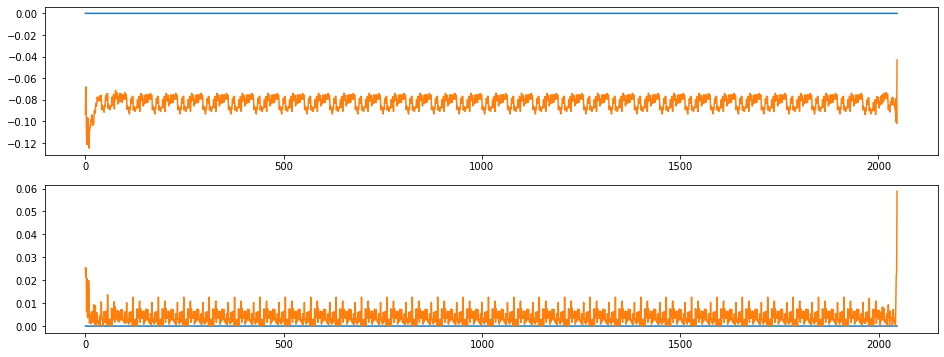

index:  90167
MAE:  0.08234366737087839
n_bunches       1308
bunch_index     1616
bunch_number    1274
Name: 588051, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_17h58m14s.h5


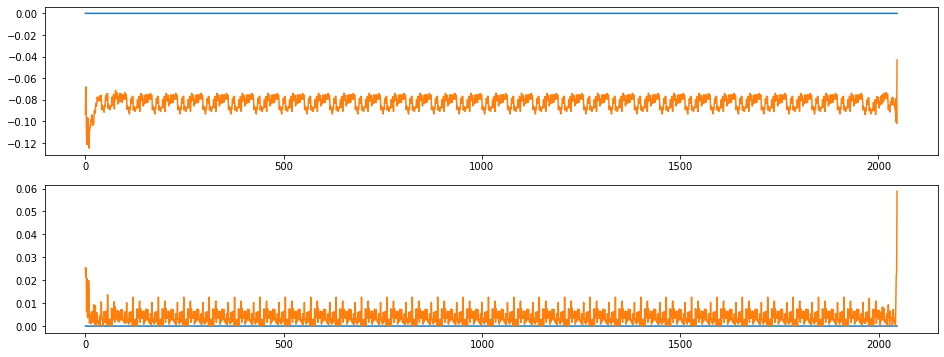

index:  167365
MAE:  0.08234366737087839
n_bunches       1868
bunch_index      703
bunch_number     381
Name: 5864864, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_23h39m14s.h5


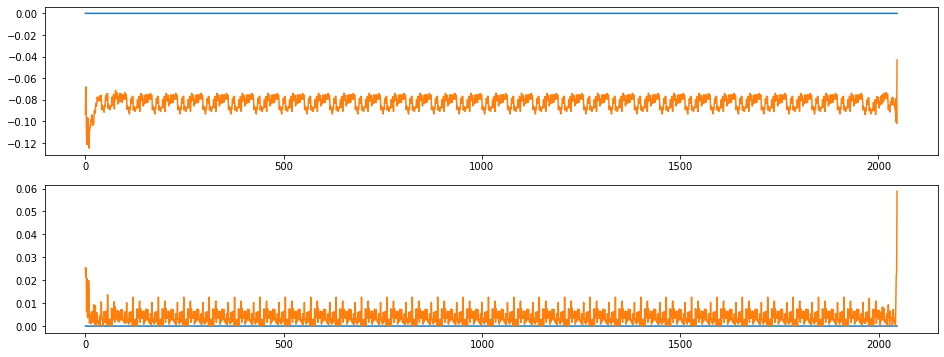

index:  324359
MAE:  0.08234366737087839
n_bunches       925
bunch_index     386
bunch_number    272
Name: 2632973, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/instability_data/06639_Inst_B1H_Q7_20180503_15h38m11s.h5


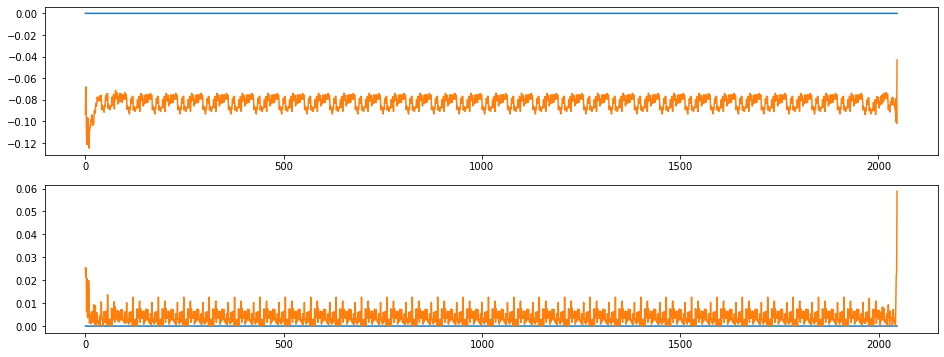

index:  121333
MAE:  0.08234366737087839
n_bunches       133
bunch_index     510
bunch_number     95
Name: 2424679, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6982/instability_data/06982_Inst_B1H_Q7_20180726_18h17m13s.h5


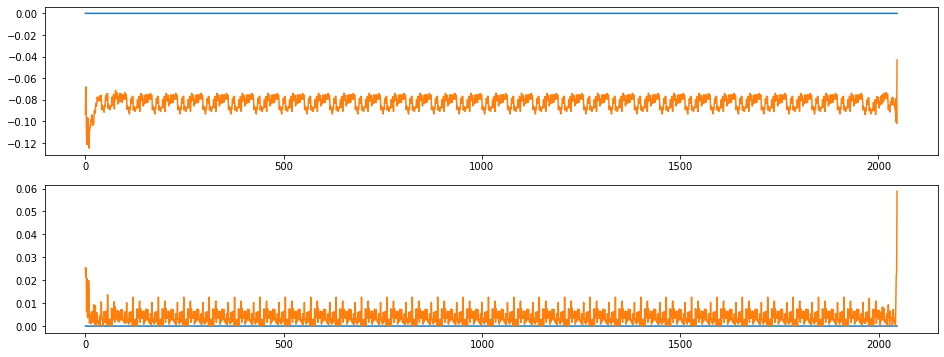

index:  81818
MAE:  0.08234366737087839
n_bunches       1812
bunch_index     1738
bunch_number     890
Name: 5113555, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_04h49m02s.h5


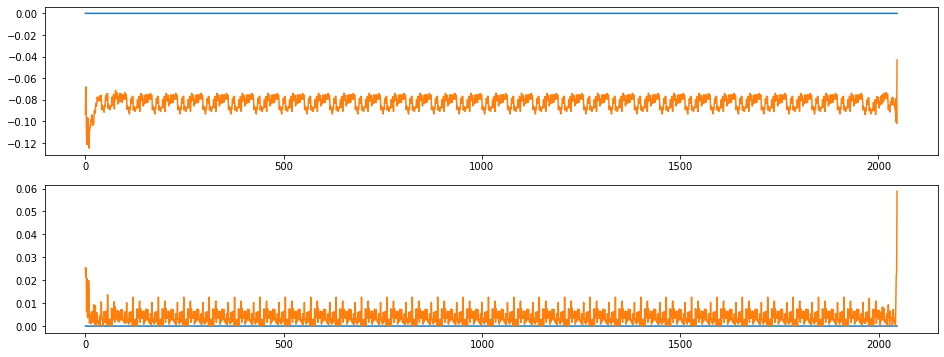

index:  19207
MAE:  0.08234366737087839
n_bunches       1916
bunch_index     1230
bunch_number     680
Name: 11356614, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_16h15m15s.h5


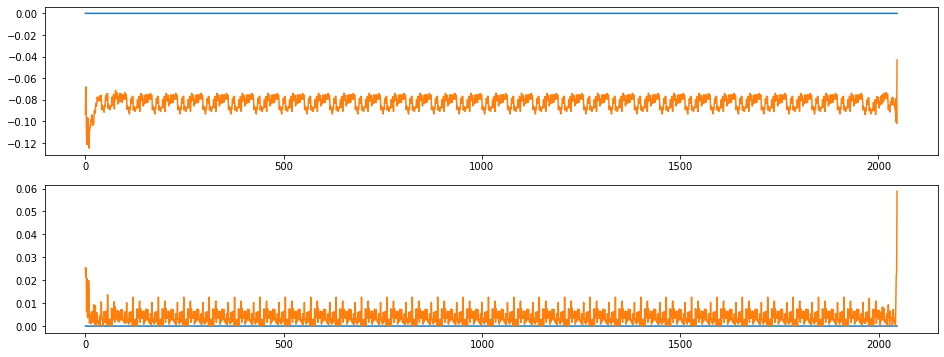

index:  96584
MAE:  0.08234366737087839
n_bunches       12
bunch_index     21
bunch_number     3
Name: 9699041, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6922/instability_data/06922_Inst_B1H_Q7_20180714_18h32m35s.h5


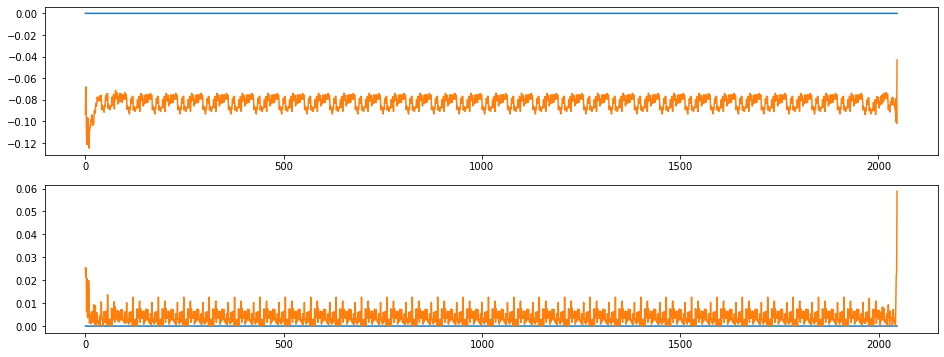

index:  111276
MAE:  0.08234366737087839
n_bunches       780
bunch_index     401
bunch_number    269
Name: 2032226, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7040/instability_data/07040_Inst_B1H_Q7_20180809_19h14m16s.h5


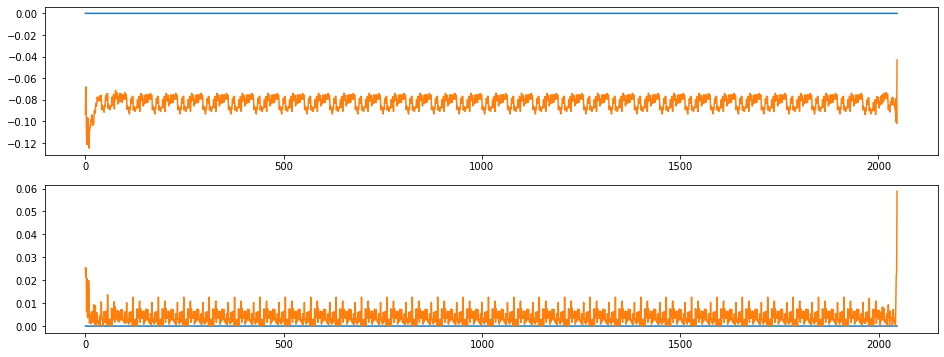

index:  136517
MAE:  0.08234366737087839
n_bunches       1836
bunch_index     1607
bunch_number     858
Name: 4198778, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_17h07m14s.h5


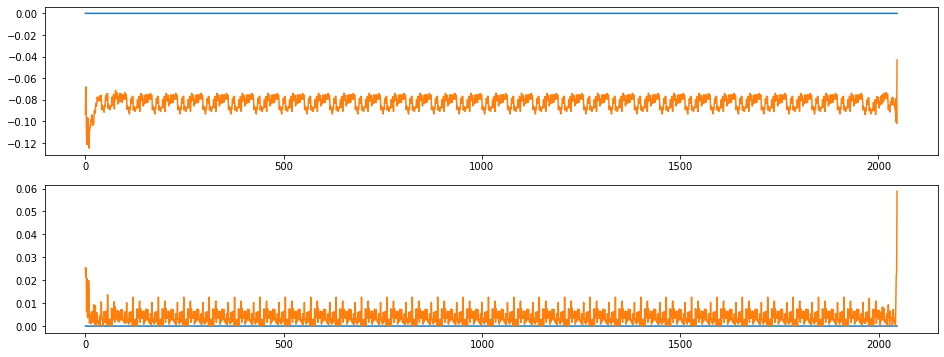

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  326238
MAE:  0.600097975508761
n_bunches       158
bunch_index     400
bunch_number     79
Name: 2408808, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7386/instability_data/07386_Inst_B1H_Q7_20181029_15h09m16s.h5


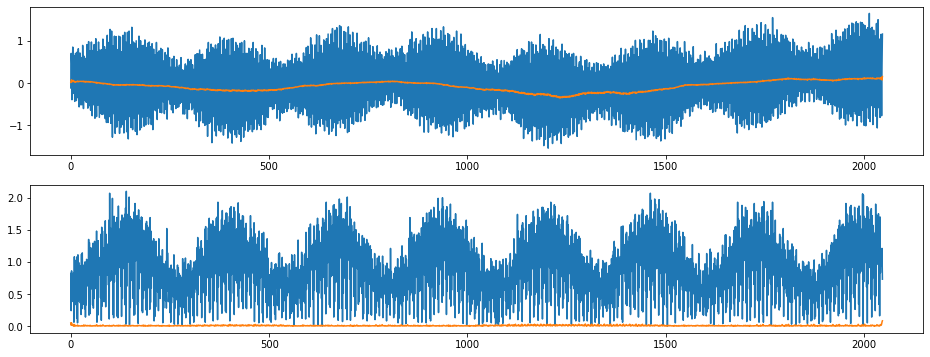

index:  325735
MAE:  0.5997960958347539
n_bunches       780
bunch_index     942
bunch_number    678
Name: 9432523, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6774/instability_data/06774_Inst_B1H_Q7_20180610_22h48m57s.h5


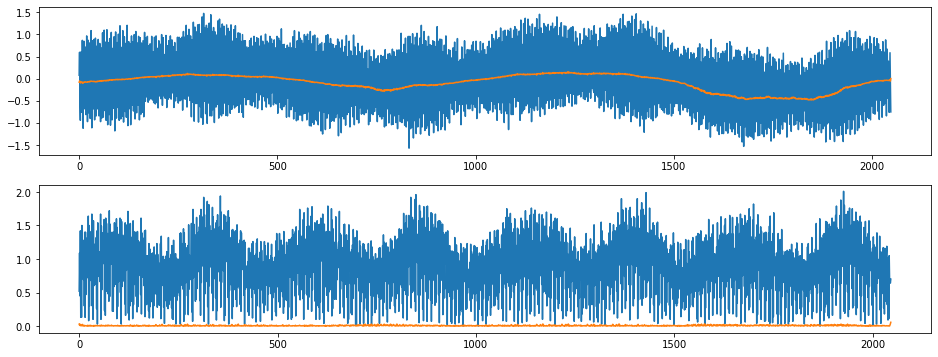

index:  191796
MAE:  0.6002215116805746
n_bunches        733
bunch_index     2061
bunch_number     433
Name: 10298277, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7487/instability_data/07487_Inst_B1H_Q7_20181201_01h07m20s.h5


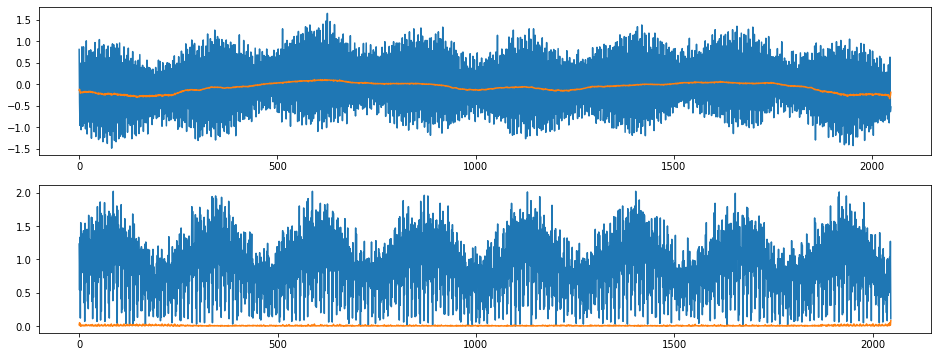

index:  356857
MAE:  0.599773802454074
n_bunches       1212
bunch_index     1103
bunch_number     794
Name: 5497705, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7234/instability_data/07234_Inst_B1H_Q7_20180929_02h45m57s.h5


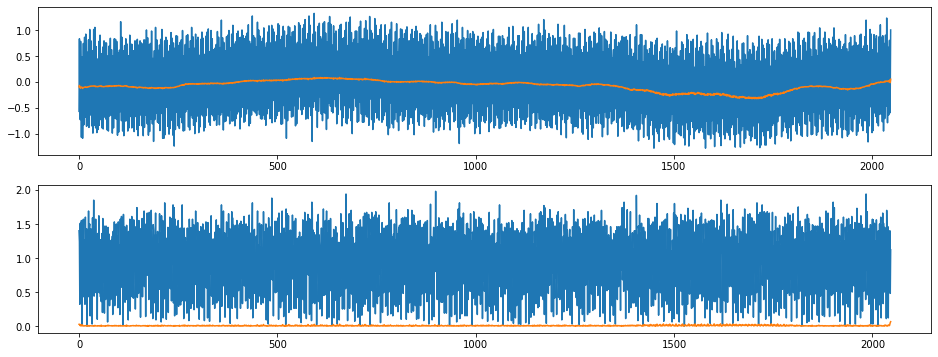

index:  58089
MAE:  0.600335059058707
n_bunches       924
bunch_index     997
bunch_number    707
Name: 1521177, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6738/instability_data/06738_Inst_B1H_Q7_20180529_00h10m07s.h5


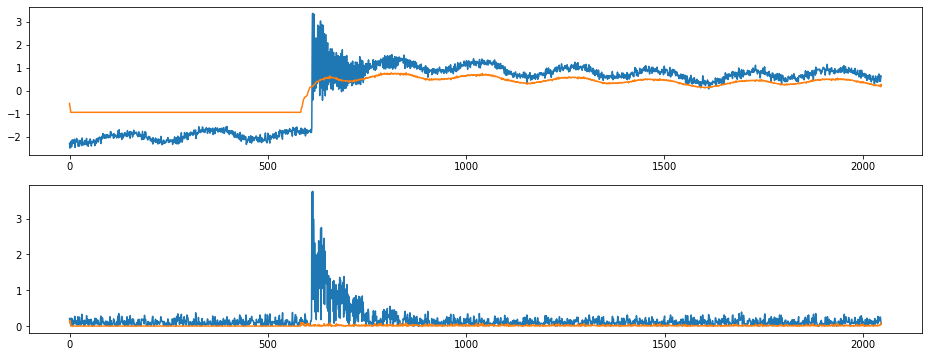

index:  326483
MAE:  0.6004373526545532
n_bunches       1308
bunch_index     1567
bunch_number    1234
Name: 1792334, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_16h57m14s.h5


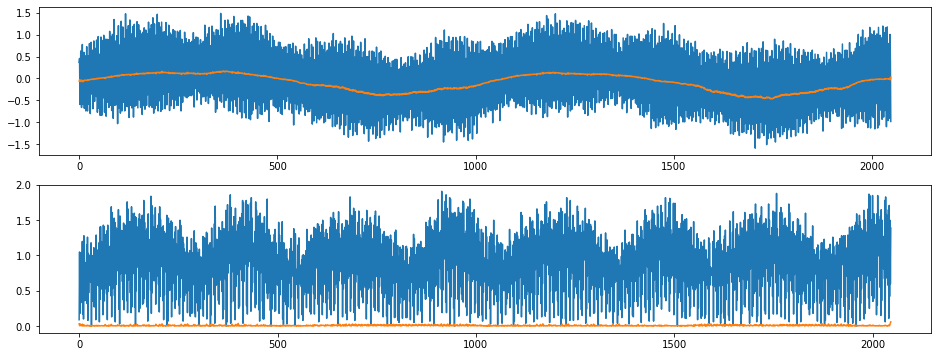

index:  321351
MAE:  0.6005210914054624
n_bunches       1916
bunch_index      596
bunch_number     319
Name: 6767233, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_22h23m14s.h5


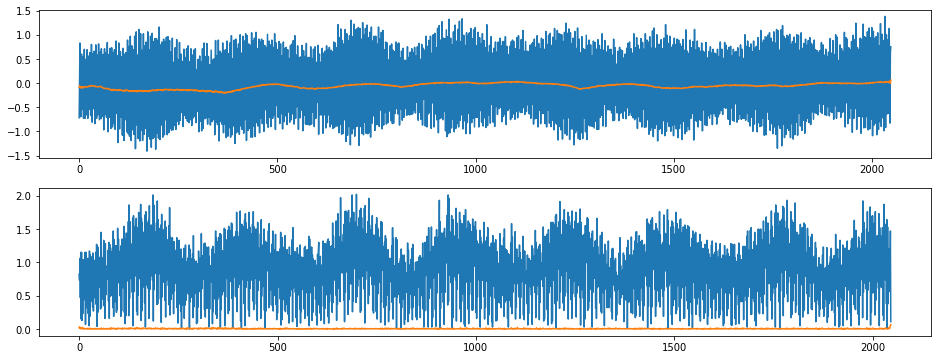

index:  354851
MAE:  0.5994679525839456
n_bunches        780
bunch_index     1040
bunch_number     762
Name: 5645128, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7232/instability_data/07232_Inst_B1H_Q7_20180928_10h07m29s.h5


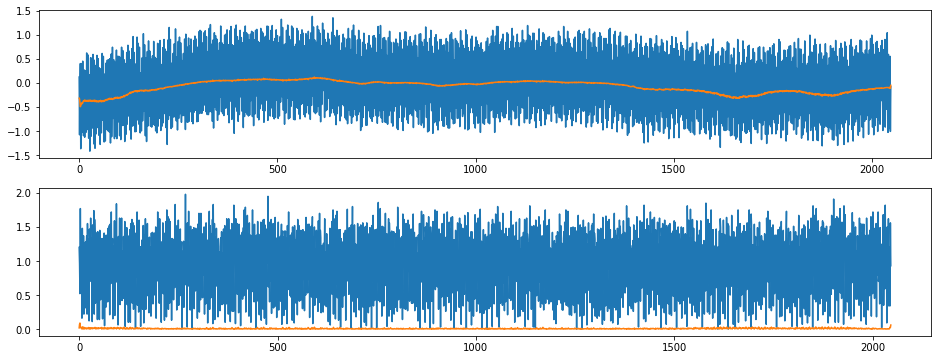

index:  324537
MAE:  0.6005481356063682
n_bunches        987
bunch_index     2380
bunch_number     738
Name: 10119450, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_20h13m14s.h5


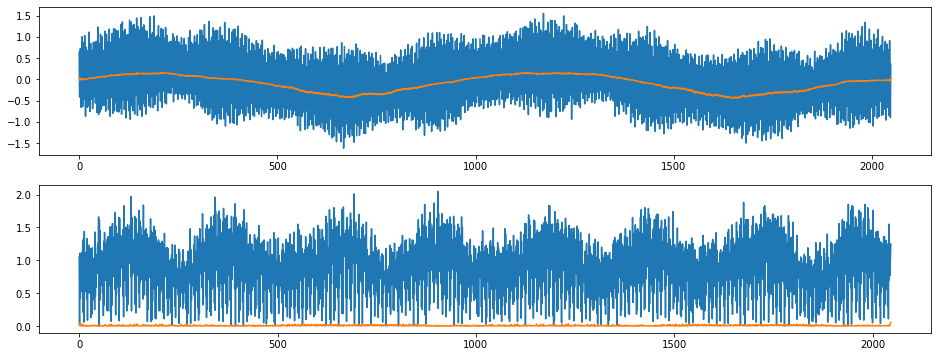

index:  322010
MAE:  0.6006554762140877
n_bunches       987
bunch_index     480
bunch_number    146
Name: 11053222, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6929/instability_data/06929_Inst_B1H_Q7_20180716_04h29m14s.h5


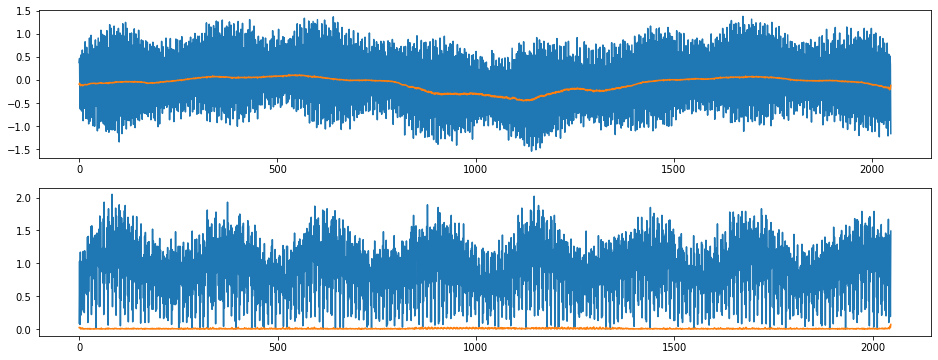

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

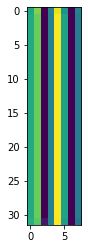

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  296131
MAE:  0.08234366737087839
n_bunches       1452
bunch_index      938
bunch_number     389
Name: 7879837, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_15h41m14s.h5


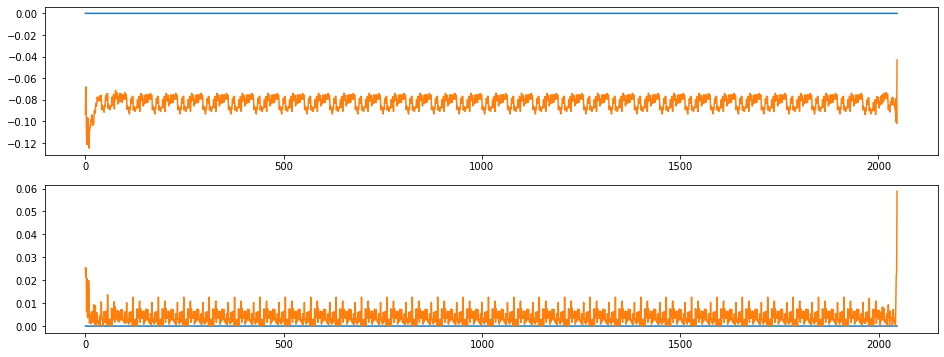

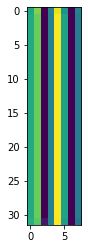

index:  90167
MAE:  0.08234366737087839
n_bunches       1308
bunch_index     1616
bunch_number    1274
Name: 588051, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_17h58m14s.h5


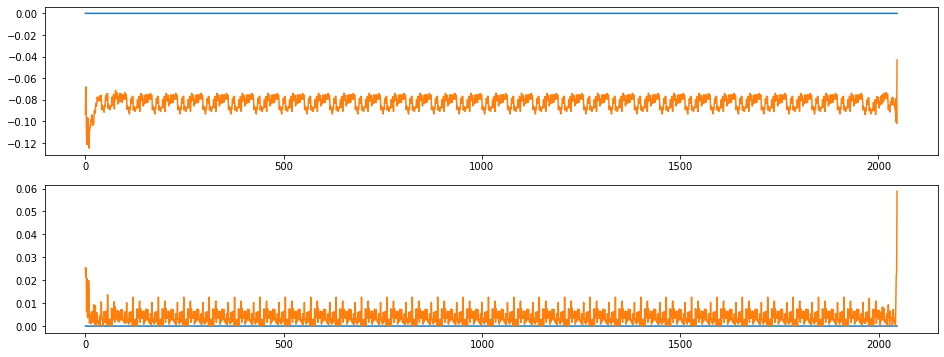

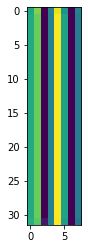

index:  167365
MAE:  0.08234366737087839
n_bunches       1868
bunch_index      703
bunch_number     381
Name: 5864864, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_23h39m14s.h5


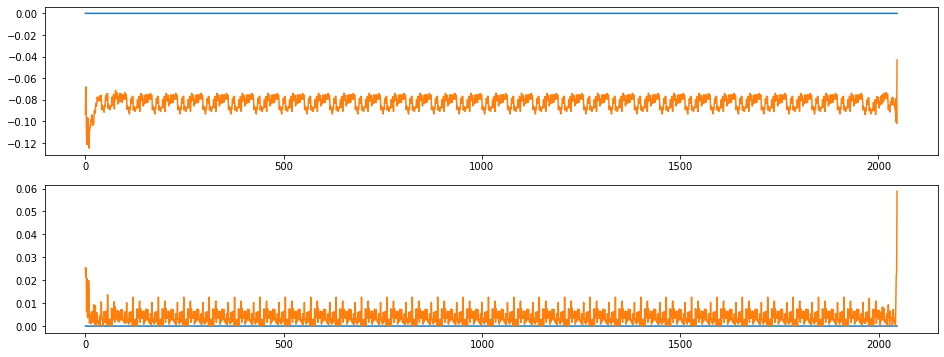

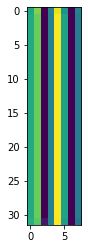

index:  324359
MAE:  0.08234366737087839
n_bunches       925
bunch_index     386
bunch_number    272
Name: 2632973, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/instability_data/06639_Inst_B1H_Q7_20180503_15h38m11s.h5


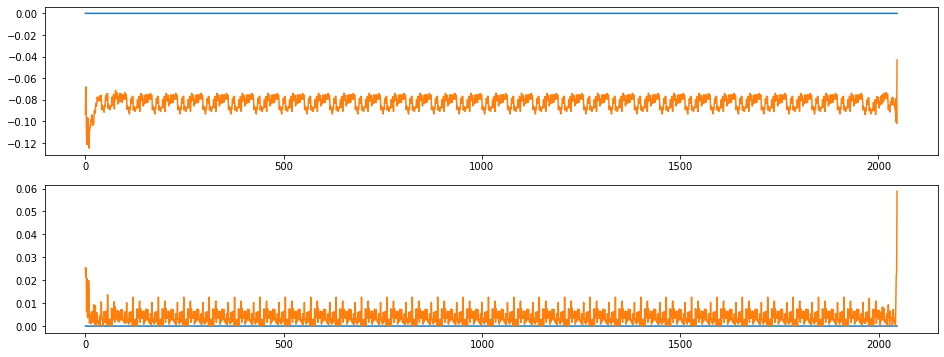

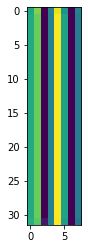

index:  121333
MAE:  0.08234366737087839
n_bunches       133
bunch_index     510
bunch_number     95
Name: 2424679, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6982/instability_data/06982_Inst_B1H_Q7_20180726_18h17m13s.h5


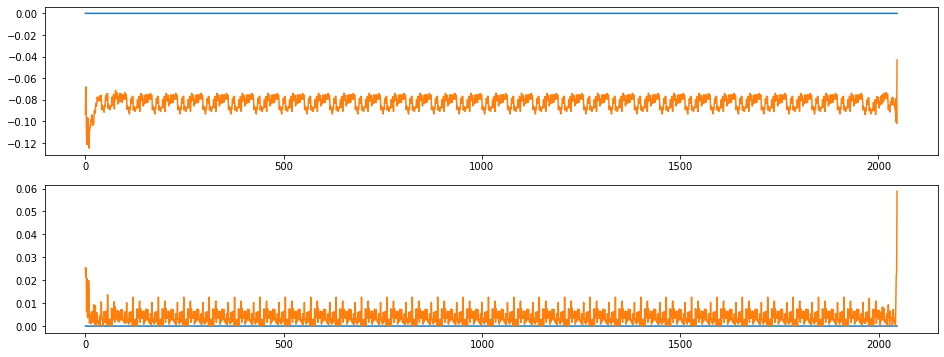

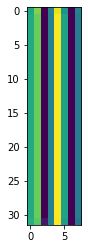

index:  81818
MAE:  0.08234366737087839
n_bunches       1812
bunch_index     1738
bunch_number     890
Name: 5113555, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_04h49m02s.h5


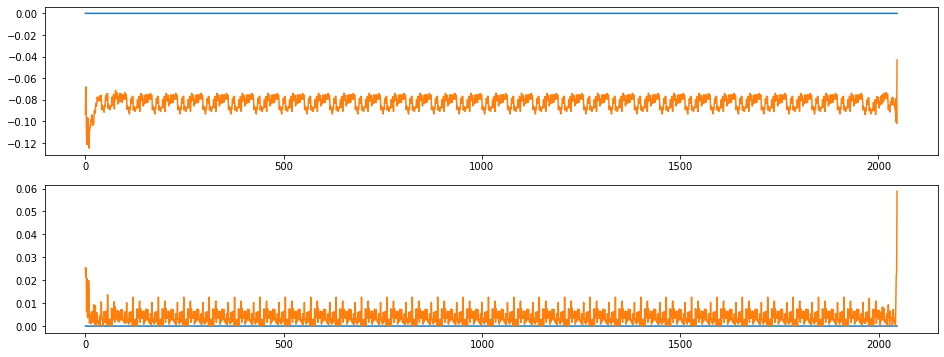

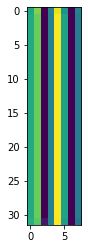

index:  19207
MAE:  0.08234366737087839
n_bunches       1916
bunch_index     1230
bunch_number     680
Name: 11356614, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_16h15m15s.h5


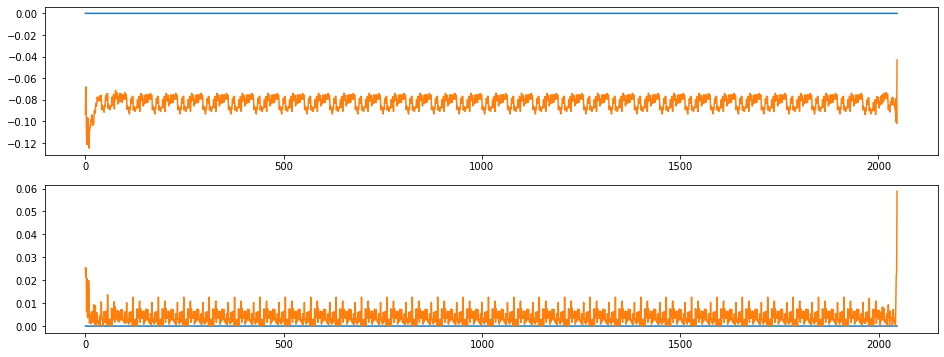

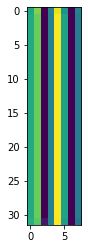

index:  96584
MAE:  0.08234366737087839
n_bunches       12
bunch_index     21
bunch_number     3
Name: 9699041, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6922/instability_data/06922_Inst_B1H_Q7_20180714_18h32m35s.h5


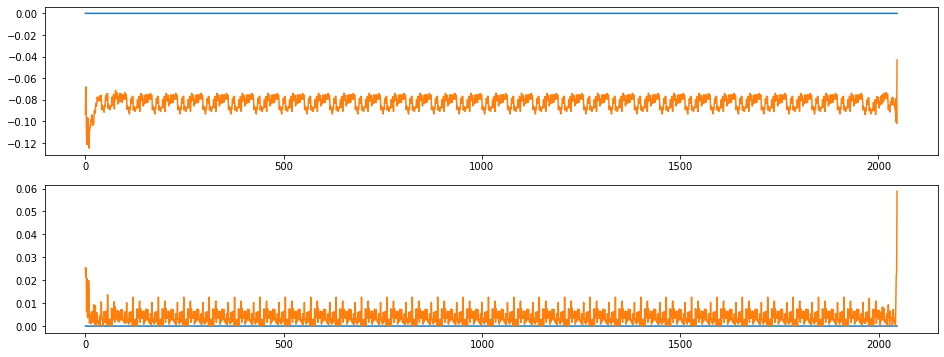

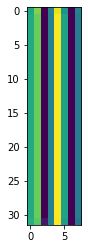

index:  111276
MAE:  0.08234366737087839
n_bunches       780
bunch_index     401
bunch_number    269
Name: 2032226, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7040/instability_data/07040_Inst_B1H_Q7_20180809_19h14m16s.h5


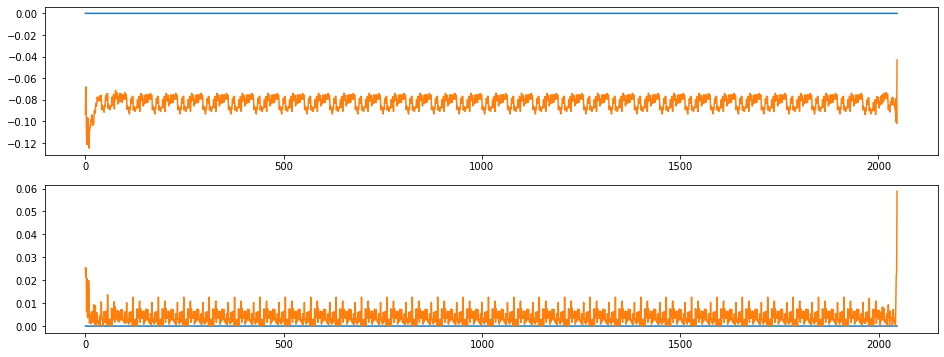

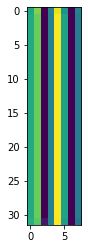

index:  136517
MAE:  0.08234366737087839
n_bunches       1836
bunch_index     1607
bunch_number     858
Name: 4198778, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_17h07m14s.h5


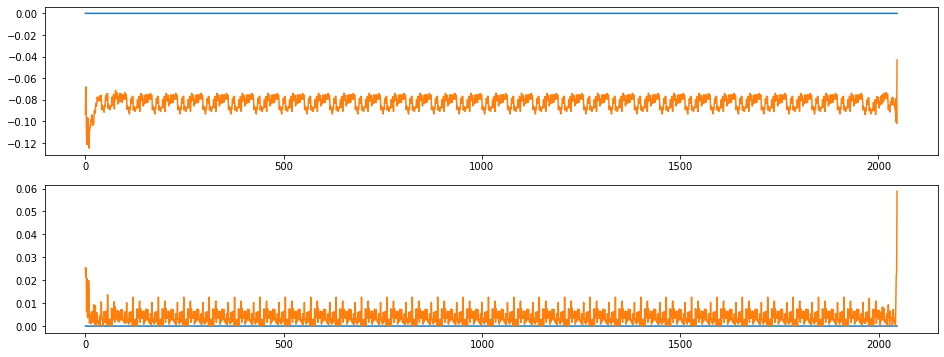

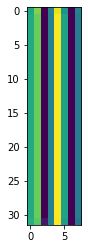

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  392349
MAE:  10.079799641700664
n_bunches        601
bunch_index     1130
bunch_number     394
Name: 7734305, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6621/instability_data/06621_Inst_B1H_Q7_20180429_04h20m45s.h5


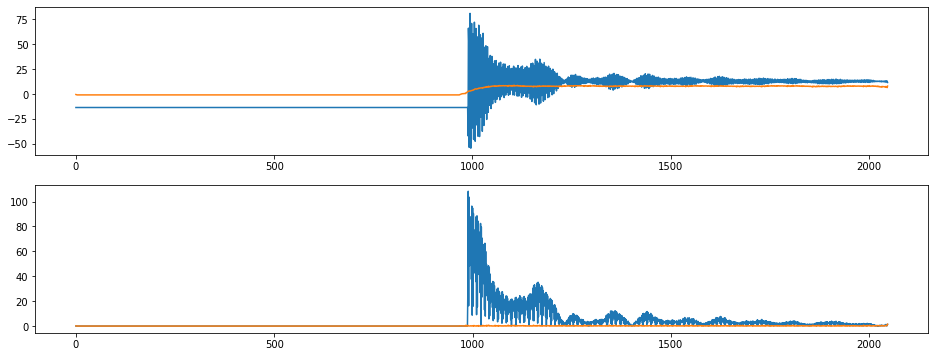

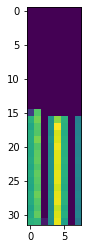

index:  87715
MAE:  10.004691808894714
n_bunches       1916
bunch_index     1206
bunch_number     664
Name: 1484472, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170930_00h40m33s.h5


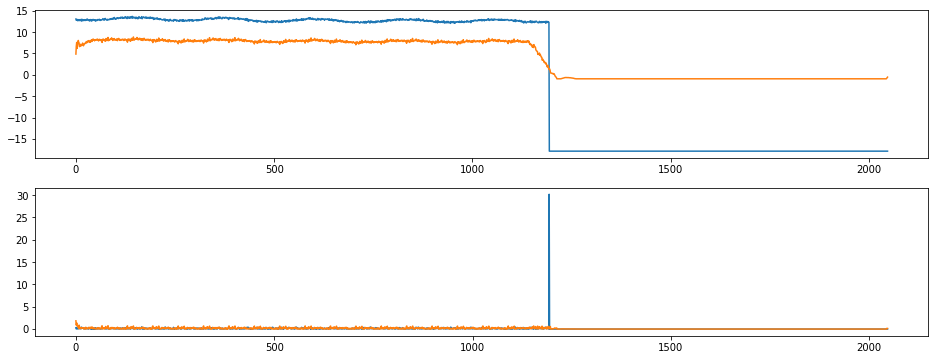

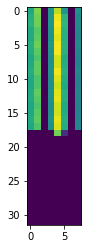

index:  61151
MAE:  9.445473176105516
n_bunches        925
bunch_index     1279
bunch_number     896
Name: 680018, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6639/instability_data/06639_Inst_B1H_Q7_20180503_15h37m43s.h5


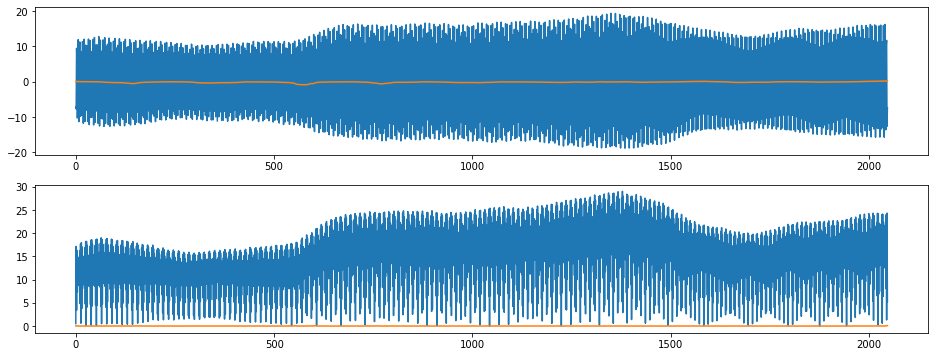

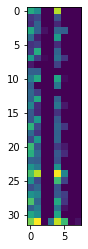

index:  171080
MAE:  9.197050944915393
n_bunches        555
bunch_index     3034
bunch_number     524
Name: 6836335, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6613/instability_data/06613_Inst_B1H_Q7_20180426_00h40m14s.h5


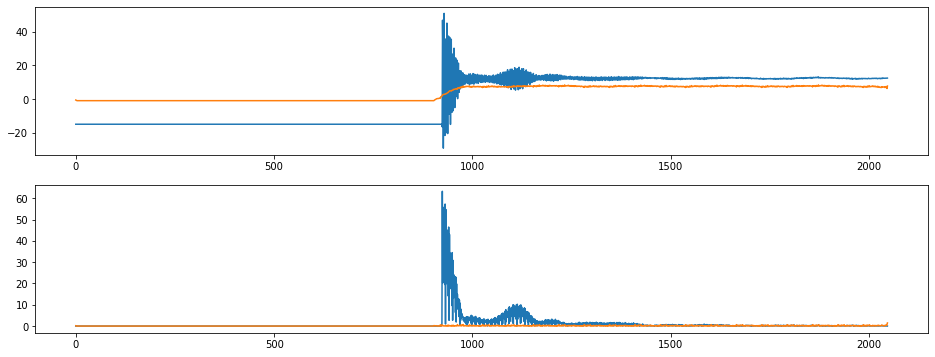

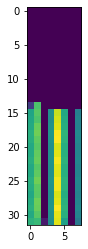

index:  297327
MAE:  8.770161165793542
n_bunches       924
bunch_index     838
bunch_number    605
Name: 9328767, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7105/instability_data/07105_Inst_B1H_Q7_20180830_10h44m14s.h5


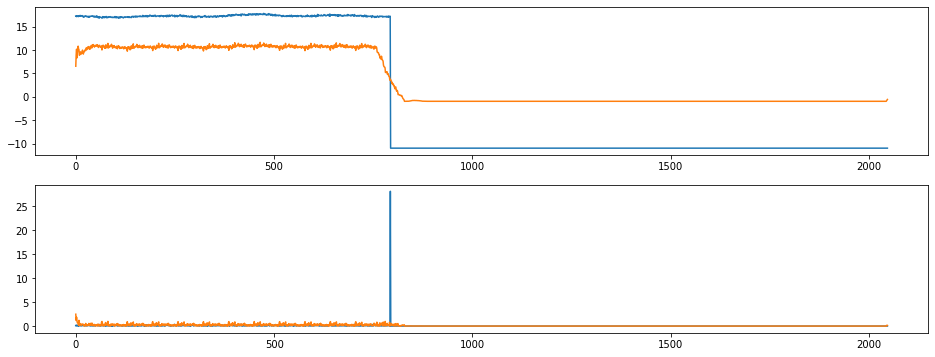

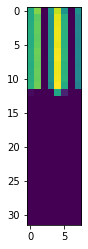

index:  64561
MAE:  8.34769789102189
n_bunches       601
bunch_index     150
bunch_number     26
Name: 3021057, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6621/instability_data/06621_Inst_B1H_Q7_20180429_04h21m24s.h5


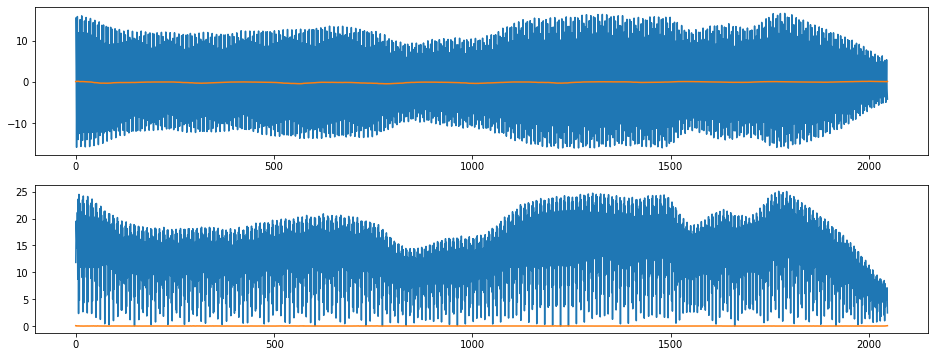

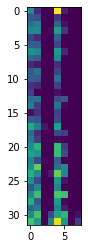

index:  227411
MAE:  8.281024380889718
n_bunches       1212
bunch_index      438
bunch_number     287
Name: 1500493, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180520_21h03m11s.h5


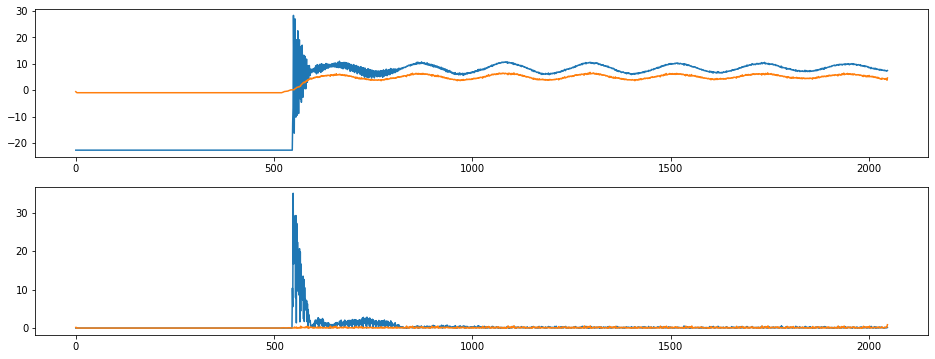

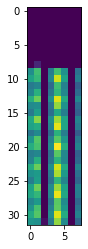

index:  3132
MAE:  8.264206866761233
n_bunches       1452
bunch_index     3334
bunch_number    1416
Name: 9695536, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6892/instability_data/06892_Inst_B1H_Q7_20180707_06h50m14s.h5


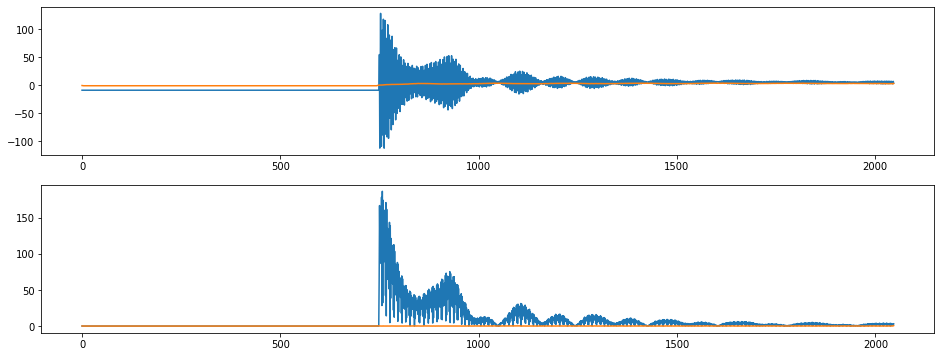

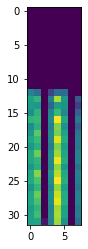

index:  59241
MAE:  8.213684031656374
n_bunches       187
bunch_index     869
bunch_number    182
Name: 10065426, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7492/instability_data/07492_Inst_B1H_Q7_20181202_15h05m04s.h5


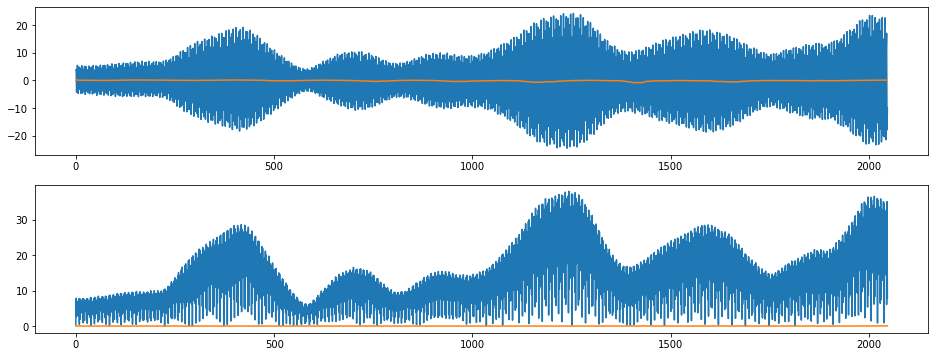

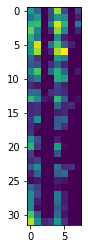

index:  344543
MAE:  8.027058870686595
n_bunches       396
bunch_index     315
bunch_number    214
Name: 6228588, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h09m54s.h5


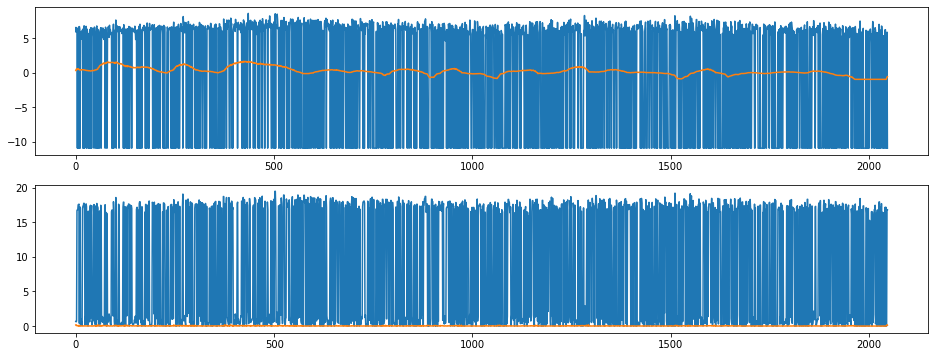

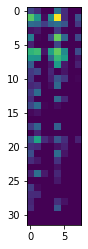

index:  356368
MAE:  7.898346892849224
n_bunches       44
bunch_index     57
bunch_number    20
Name: 1859921, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6275/instability_data/06275_Inst_B1H_Q7_20171005_19h32m14s.h5


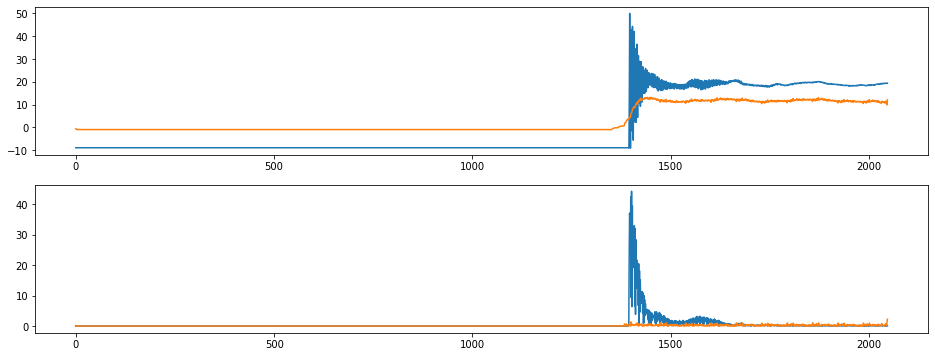

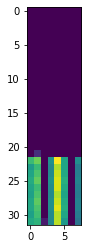

index:  286631
MAE:  7.874444361207133
n_bunches       2556
bunch_index     1146
bunch_number     830
Name: 7261675, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_22h11m14s.h5


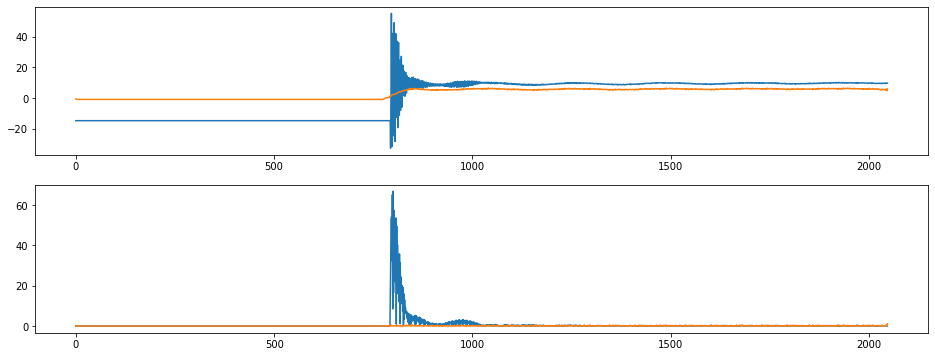

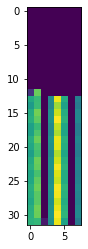

index:  383070
MAE:  7.528910272568172
n_bunches       2556
bunch_index     1578
bunch_number    1153
Name: 5342848, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/instability_data/06663_Inst_B1H_Q7_20180510_15h03m16s.h5


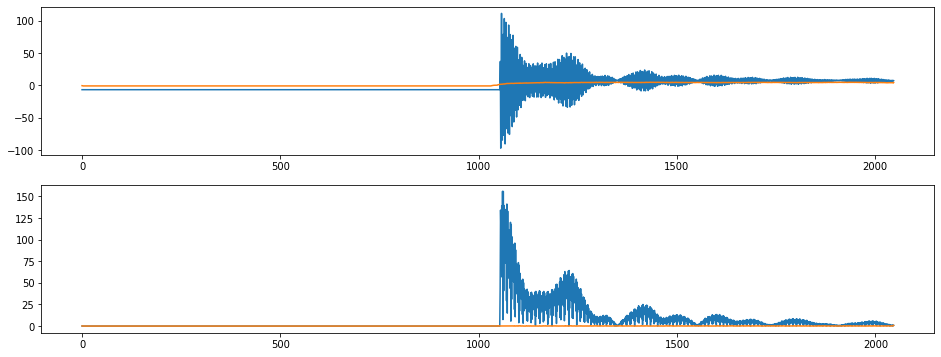

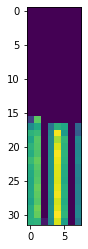

index:  275044
MAE:  7.499713383868366
n_bunches       1020
bunch_index     1380
bunch_number     641
Name: 9060564, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7353/instability_data/07353_Inst_B1H_Q7_20181025_19h05m15s.h5


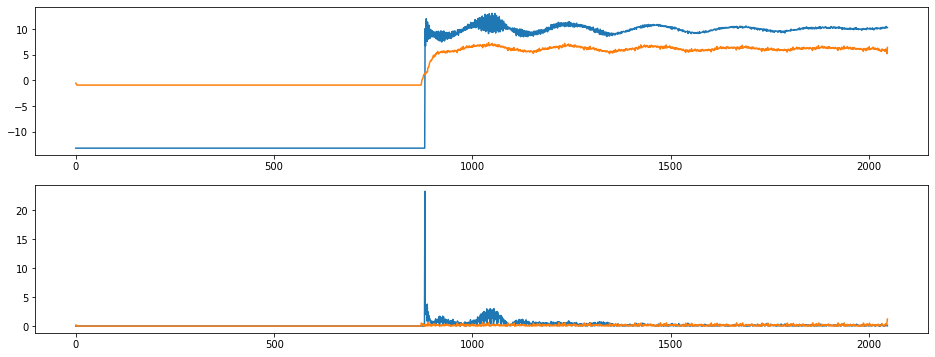

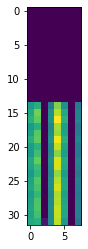

index:  348587
MAE:  7.448713152230484
n_bunches       2556
bunch_index     2702
bunch_number    1994
Name: 2160189, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_08h58m14s.h5


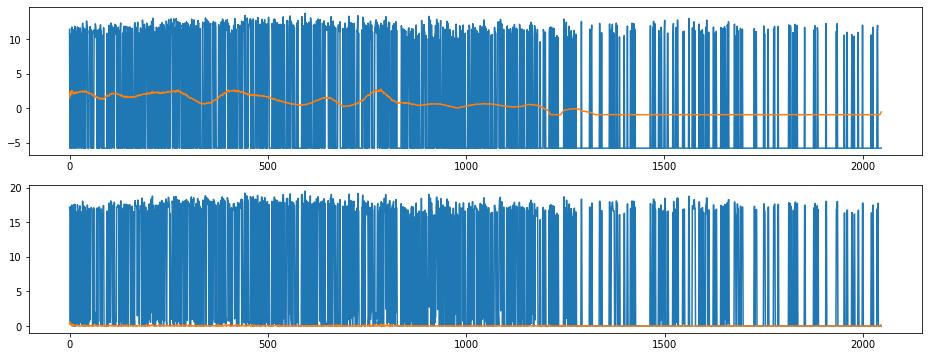

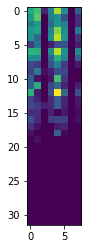

index:  65126
MAE:  7.328575069108629
n_bunches       540
bunch_index     266
bunch_number    166
Name: 3052869, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/instability_data/06860_Inst_B1H_Q7_20180628_16h40m19s.h5


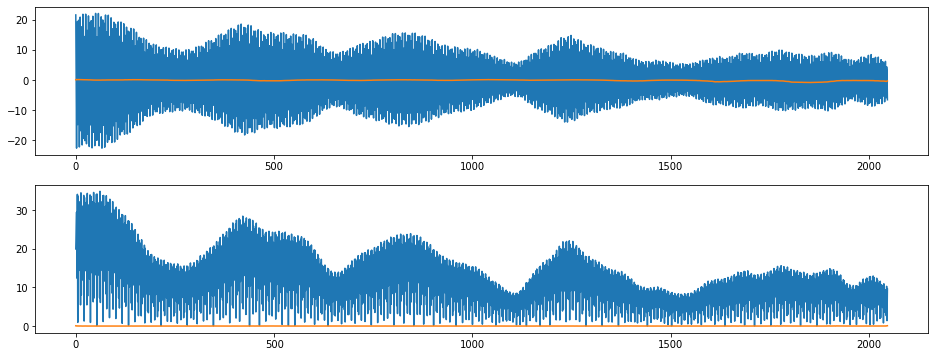

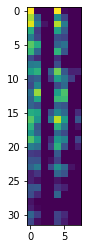

index:  210429
MAE:  7.253172587509399
n_bunches       1868
bunch_index     2755
bunch_number    1480
Name: 9567182, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6279/instability_data/06279_Inst_B1H_Q7_20171007_11h43m14s.h5


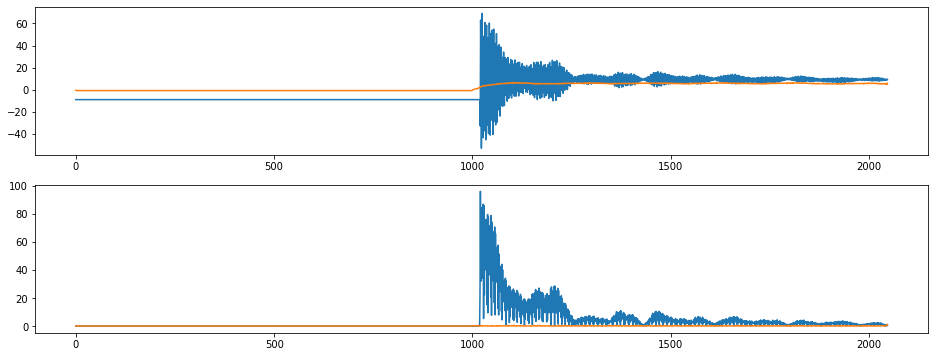

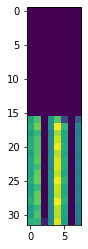

index:  167749
MAE:  7.072905548753331
n_bunches       1212
bunch_index     1513
bunch_number    1114
Name: 6252667, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7314/instability_data/07314_Inst_B1H_Q7_20181017_23h27m12s.h5


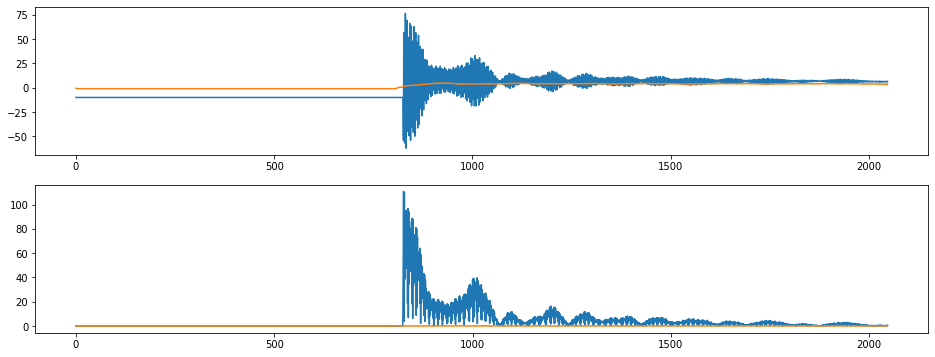

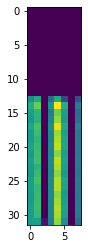

index:  376903
MAE:  6.7783346521393115
n_bunches       924
bunch_index      84
bunch_number     35
Name: 5657521, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6961/instability_data/06961_Inst_B1H_Q7_20180722_19h30m15s.h5


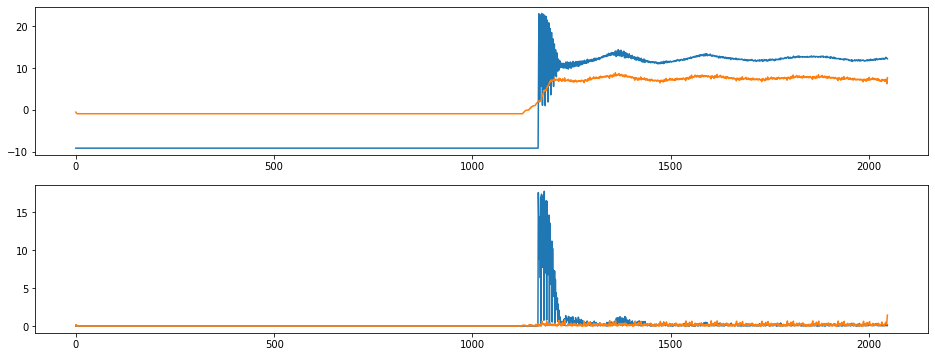

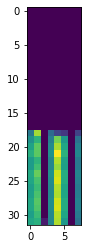

index:  324729
MAE:  6.774264356482018
n_bunches       1916
bunch_index      299
bunch_number     159
Name: 6289499, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/instability_data/06245_Inst_B1H_Q7_20170926_16h35m15s.h5


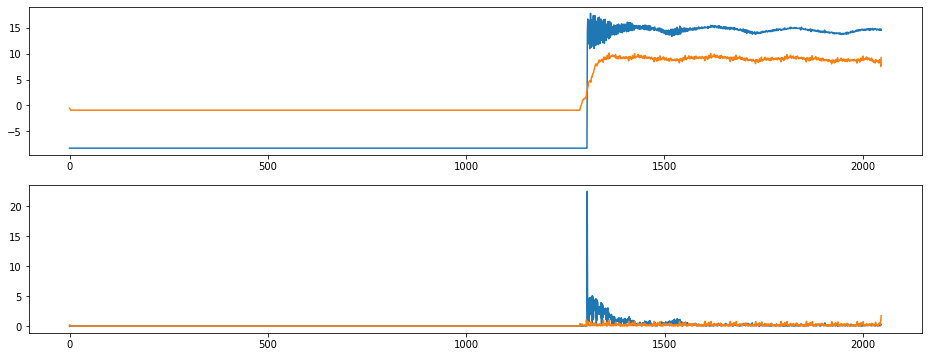

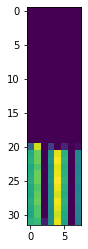

index:  394088
MAE:  6.711970654255712
n_bunches       924
bunch_index     916
bunch_number    652
Name: 6186450, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/instability_data/07052_Inst_B1H_Q7_20180813_13h08m55s.h5


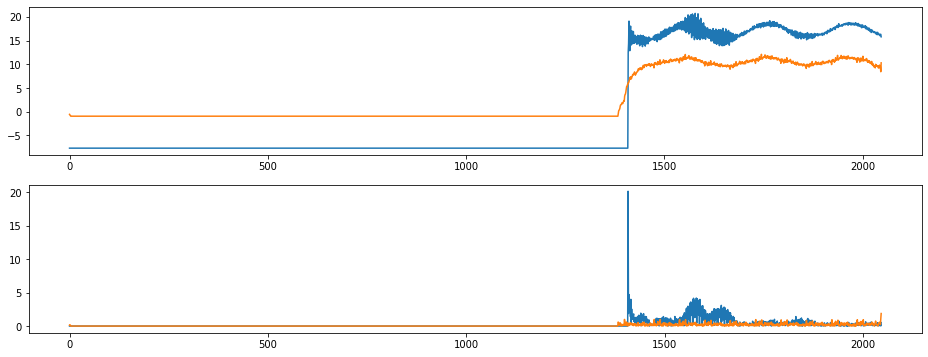

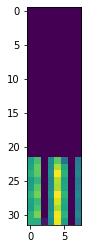

index:  176833
MAE:  6.541541475318809
n_bunches       1227
bunch_index     1133
bunch_number     397
Name: 7478138, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6624/instability_data/06624_Inst_B1H_Q7_20180430_05h23m15s.h5


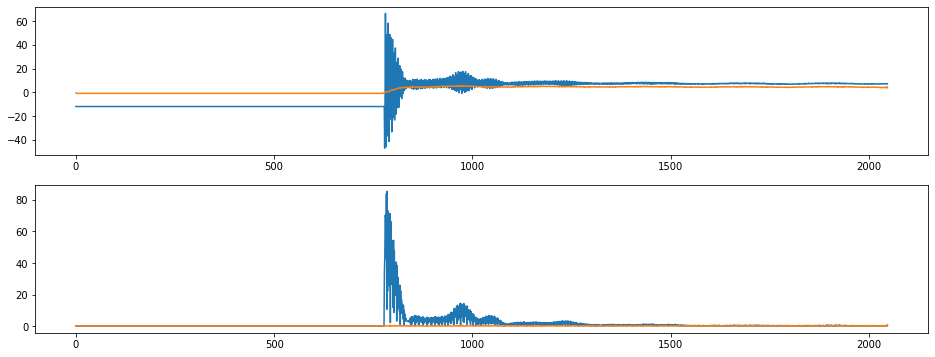

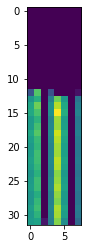

index:  348235
MAE:  6.242527153963238
n_bunches       2556
bunch_index     3202
bunch_number    2390
Name: 73533, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_20h52m14s.h5


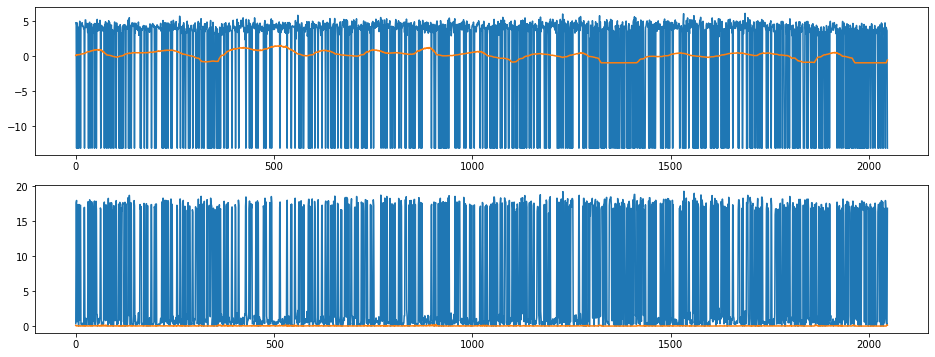

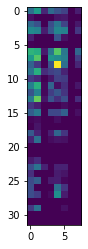

index:  52636
MAE:  6.205989651726412
n_bunches        120
bunch_index     2167
bunch_number      95
Name: 10027691, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7300/instability_data/07300_Inst_B1H_Q7_20181014_09h27m35s.h5


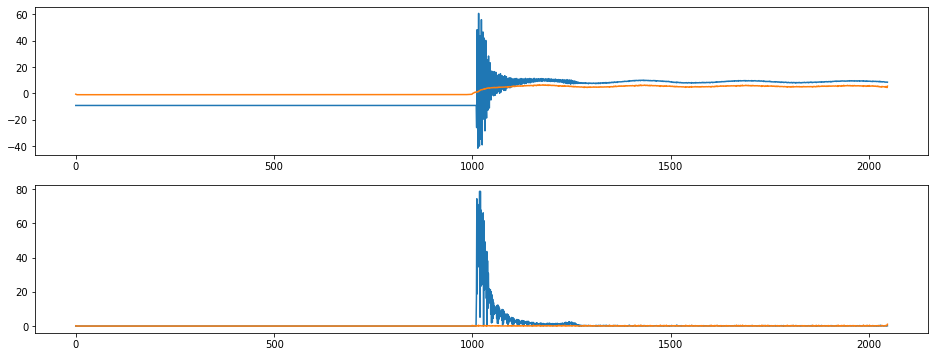

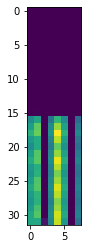

index:  369990
MAE:  6.091577671544366
n_bunches       252
bunch_index     340
bunch_number    239
Name: 7386430, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6956/instability_data/06956_Inst_B1H_Q7_20180721_09h05m42s.h5


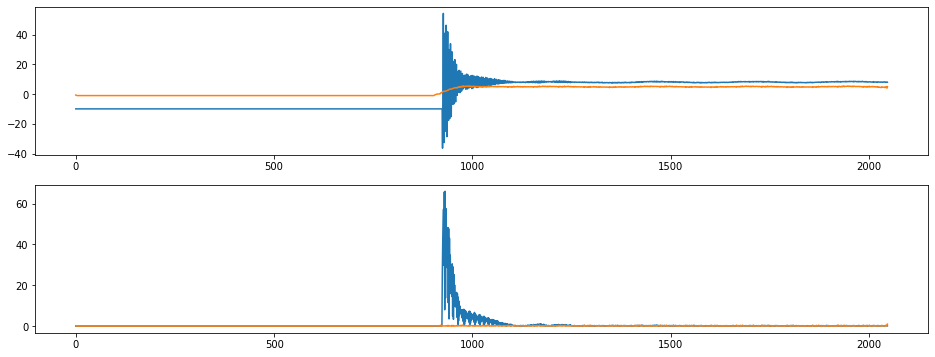

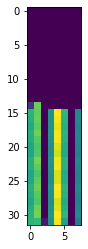

index:  324661
MAE:  6.017796747066825
n_bunches        408
bunch_index     1840
bunch_number     188
Name: 4548922, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_06h56m01s.h5


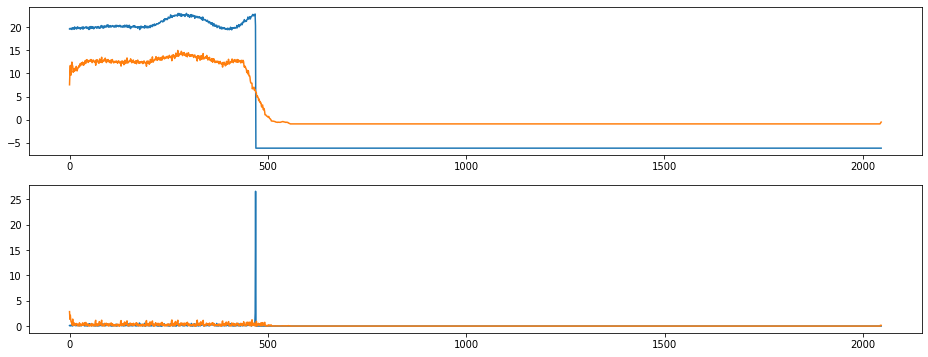

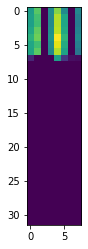

index:  150186
MAE:  5.912795599464154
n_bunches       264
bunch_index     606
bunch_number    258
Name: 9006065, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_18h07m13s.h5


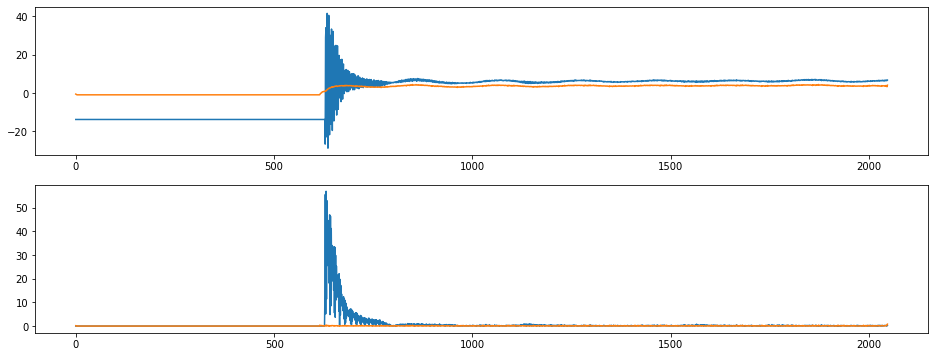

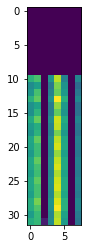

index:  94042
MAE:  5.843985154211332
n_bunches       2556
bunch_index     2293
bunch_number    1703
Name: 9846265, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_17h11m14s.h5


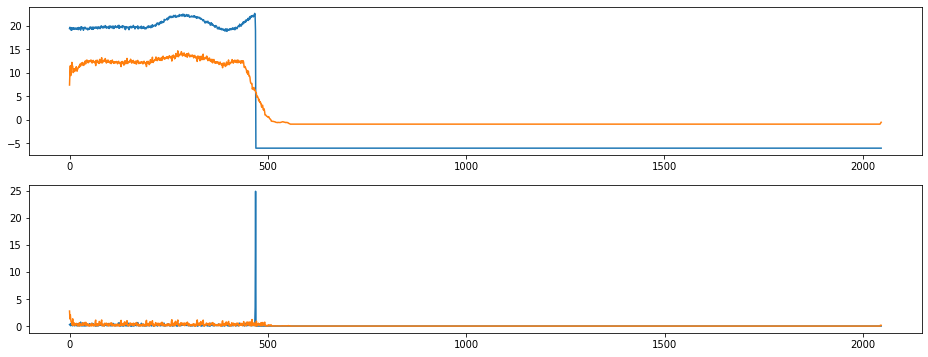

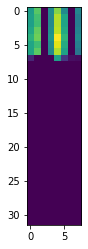

index:  259304
MAE:  5.827642140786413
n_bunches       2556
bunch_index     3195
bunch_number    2383
Name: 7055874, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7133/instability_data/07133_Inst_B1H_Q7_20180907_16h23m14s.h5


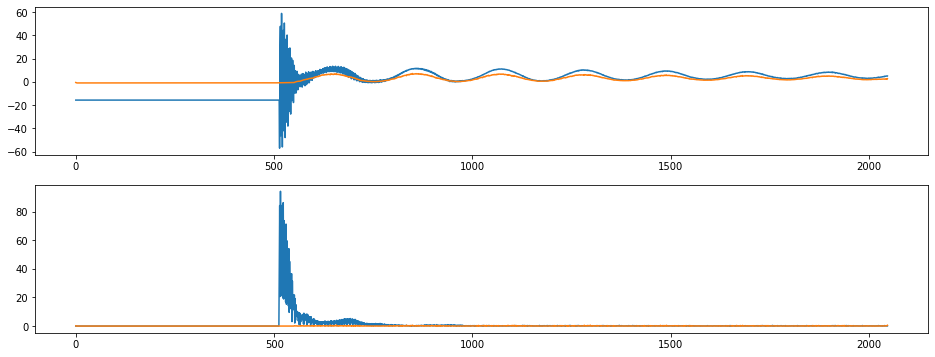

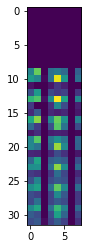

index:  64685
MAE:  5.773859948712342
n_bunches       2556
bunch_index     2654
bunch_number    1958
Name: 2749880, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6674/instability_data/06674_Inst_B1H_Q7_20180512_05h02m04s.h5


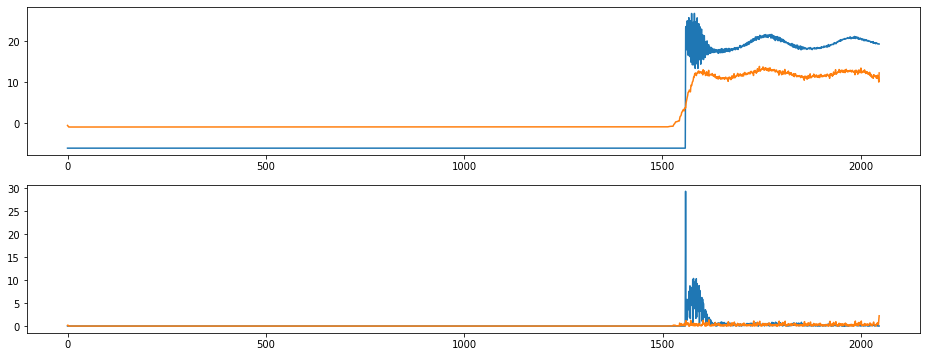

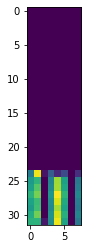

index:  213253
MAE:  5.7233898705356845
n_bunches        652
bunch_index     1057
bunch_number     560
Name: 9531206, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_17h34m58s.h5


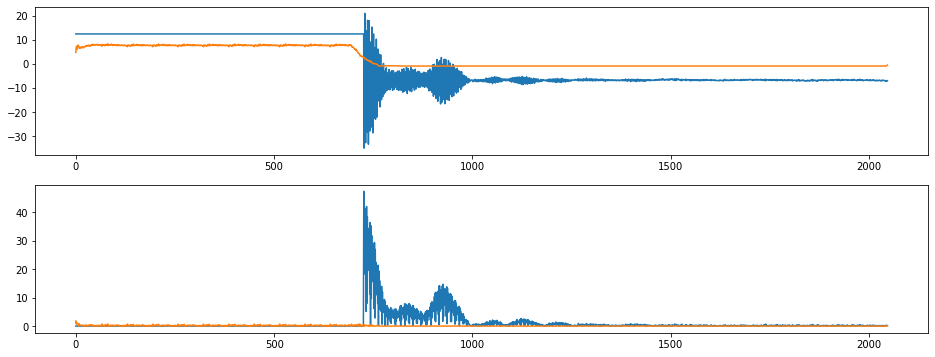

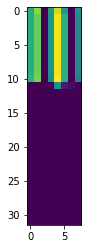

index:  52959
MAE:  5.71637314876134
n_bunches        972
bunch_index     1152
bunch_number     830
Name: 11606606, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6900/instability_data/06900_Inst_B1H_Q7_20180708_01h59m16s.h5


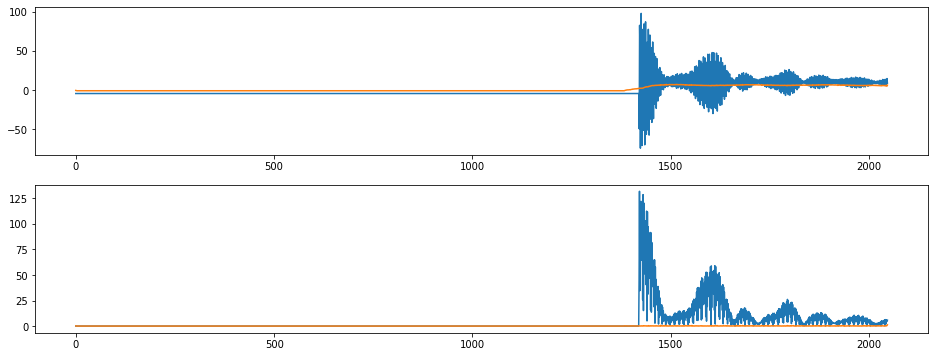

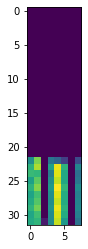

index:  50774
MAE:  5.610316481424815
n_bunches       636
bunch_index     513
bunch_number    367
Name: 5611045, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7017/instability_data/07017_Inst_B1H_Q7_20180803_08h05m34s.h5


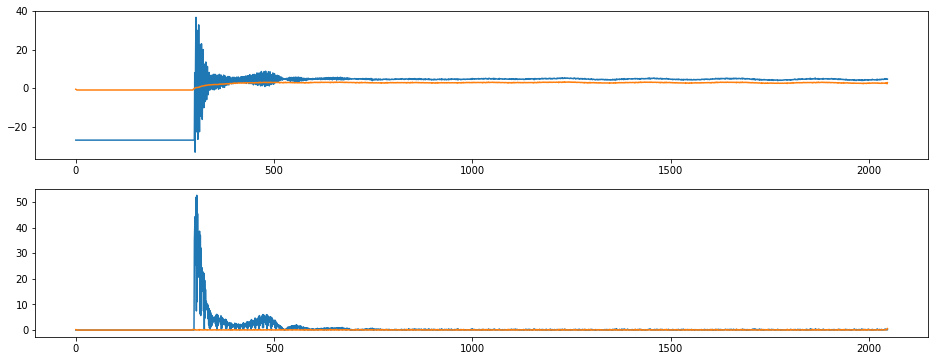

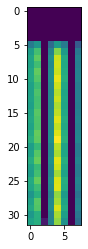

index:  281098
MAE:  5.581308409237973
n_bunches       2556
bunch_index     1410
bunch_number    1023
Name: 4413729, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_10h17m14s.h5


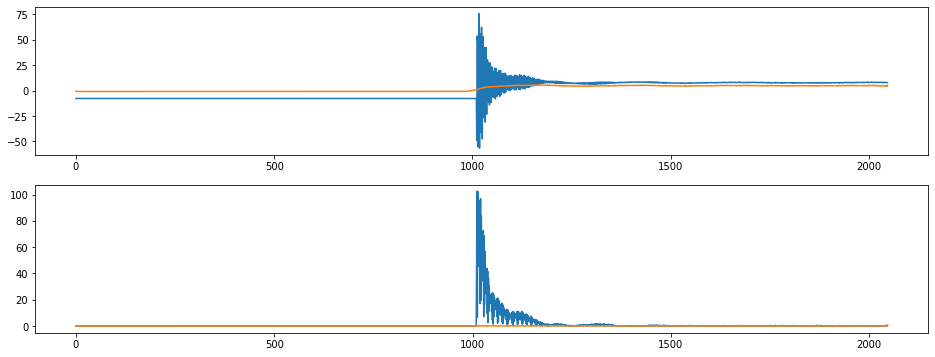

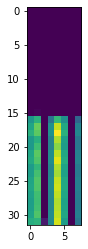

index:  113218
MAE:  5.475592133739411
n_bunches       252
bunch_index     129
bunch_number     73
Name: 6026515, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6935/instability_data/06935_Inst_B1H_Q7_20180717_13h30m15s.h5


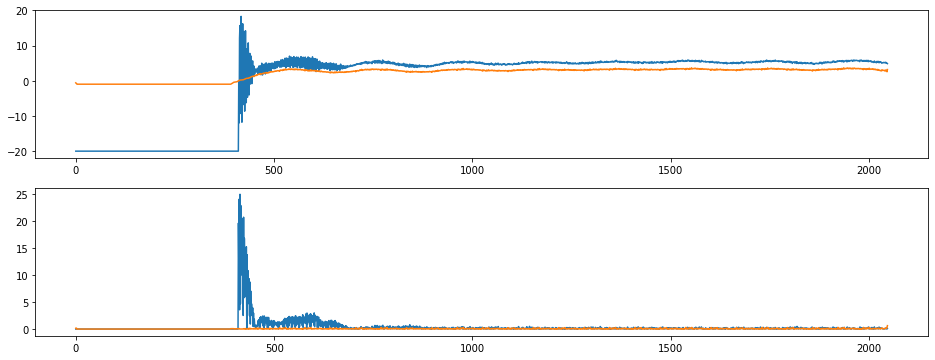

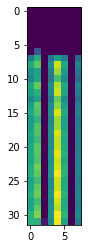

index:  61873
MAE:  5.467833955926253
n_bunches       313
bunch_index     422
bunch_number    128
Name: 8654467, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6850/instability_data/06850_Inst_B1H_Q7_20180626_20h06m28s.h5


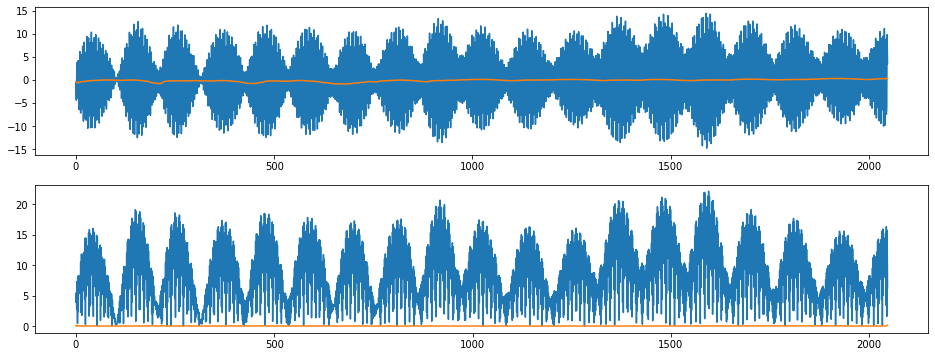

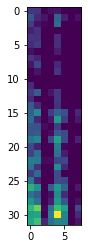

index:  314379
MAE:  5.4549880730341815
n_bunches        38
bunch_index     298
bunch_number     12
Name: 1300403, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7303/instability_data/07303_Inst_B1H_Q7_20181014_23h28m14s.h5


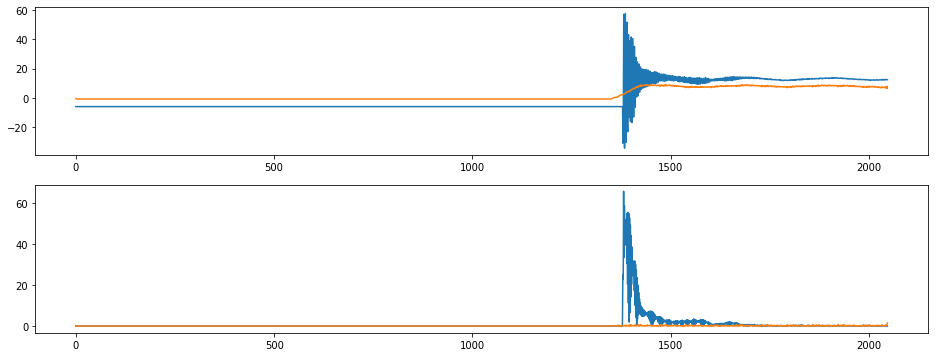

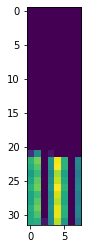

index:  403817
MAE:  5.436404854168286
n_bunches        733
bunch_index     2440
bunch_number     515
Name: 4890949, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7491/instability_data/07491_Inst_B1H_Q7_20181202_09h33m14s.h5


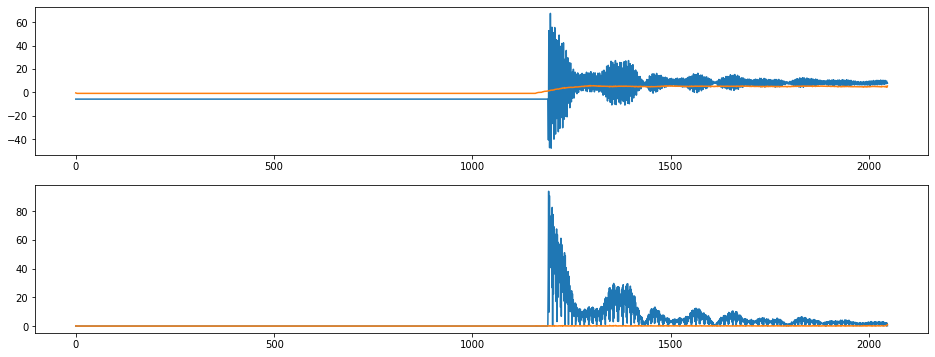

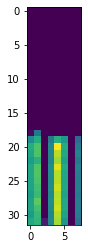

index:  248254
MAE:  5.335996735443841
n_bunches       924
bunch_index     479
bunch_number    340
Name: 4337805, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7265/instability_data/07265_Inst_B1H_Q7_20181007_22h30m48s.h5


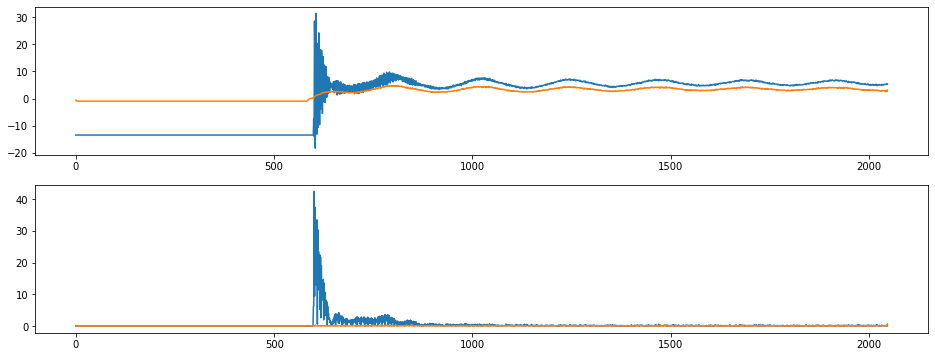

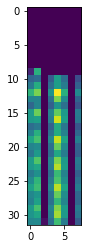

index:  339059
MAE:  5.332960104078085
n_bunches       780
bunch_index     865
bunch_number    632
Name: 2346555, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/instability_data/07135_Inst_B1H_Q7_20180907_18h41m15s.h5


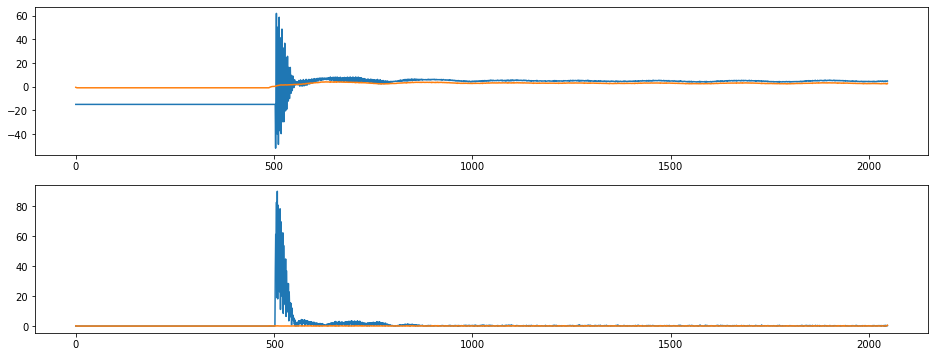

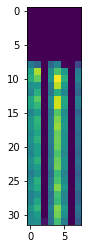

index:  90137
MAE:  5.190360900228552
n_bunches       204
bunch_index     307
bunch_number    153
Name: 4891728, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6266/instability_data/06266_Inst_B1H_Q7_20171002_18h19m41s.h5


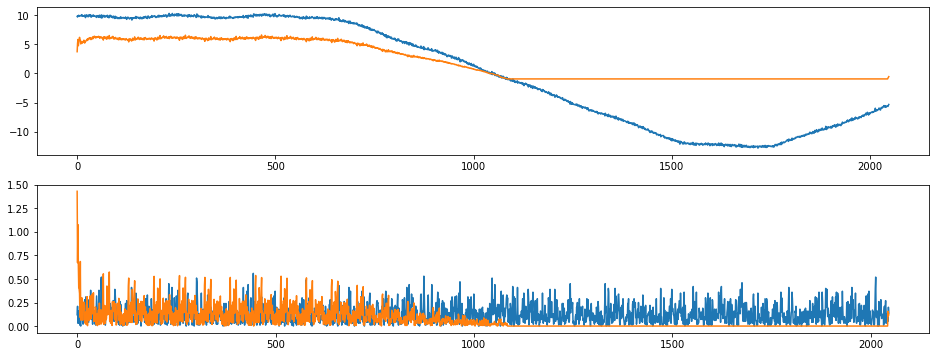

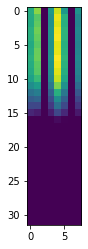

index:  130668
MAE:  5.167259525019108
n_bunches       1916
bunch_index     1103
bunch_number     596
Name: 735905, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/instability_data/06245_Inst_B1H_Q7_20170926_18h52m14s.h5


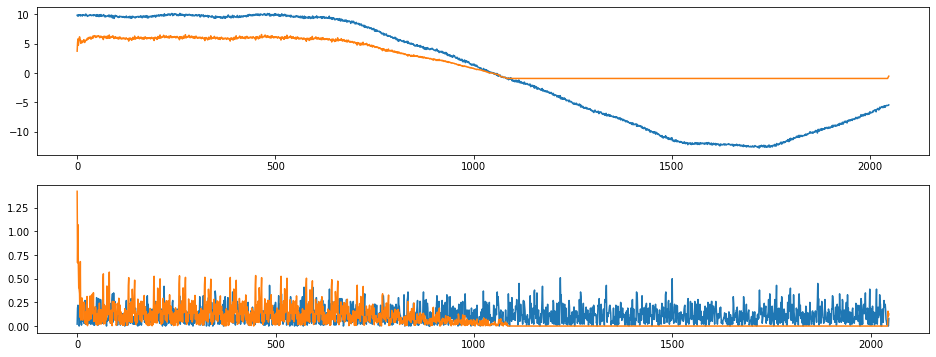

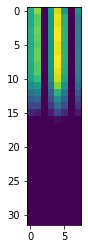

index:  275623
MAE:  5.0429340916514045
n_bunches       780
bunch_index     472
bunch_number    314
Name: 4466591, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6741/instability_data/06741_Inst_B1H_Q7_20180530_10h06m14s.h5


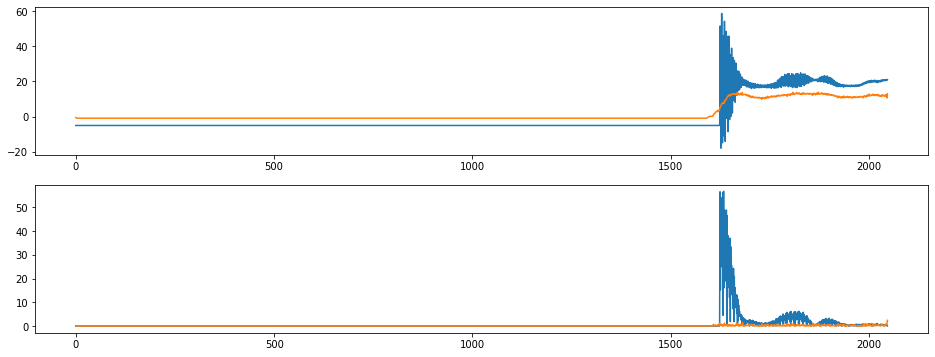

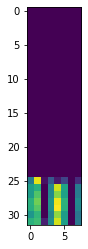

index:  206175
MAE:  4.883111065115228
n_bunches       780
bunch_index     360
bunch_number    180
Name: 2180001, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6415/instability_data/06415_Inst_B1H_Q7_20171125_04h18m24s.h5


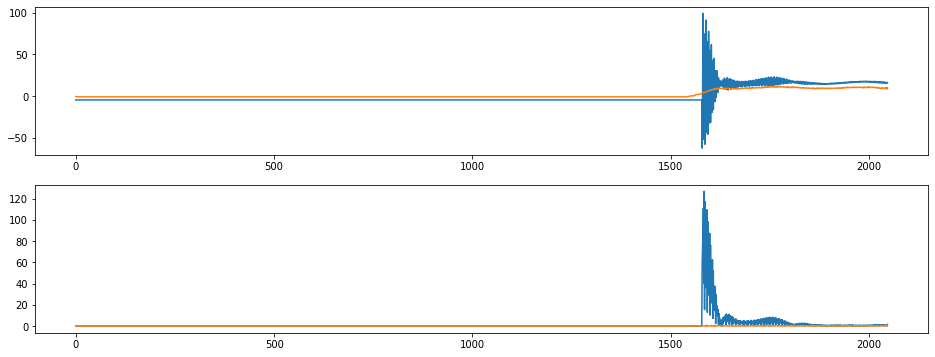

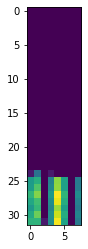

index:  217265
MAE:  4.863301398923068
n_bunches          2
bunch_index     2086
bunch_number       1
Name: 10678878, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6367/instability_data/06367_Inst_B1H_Q7_20171108_11h45m14s.h5


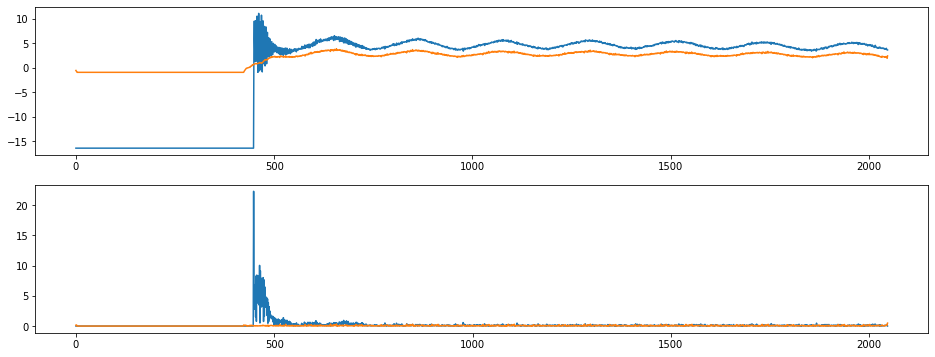

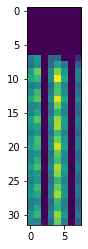

index:  260781
MAE:  4.851962805788062
n_bunches       68
bunch_index     99
bunch_number    45
Name: 10831942, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/instability_data/06254_Inst_B1H_Q7_20170929_05h17m34s.h5


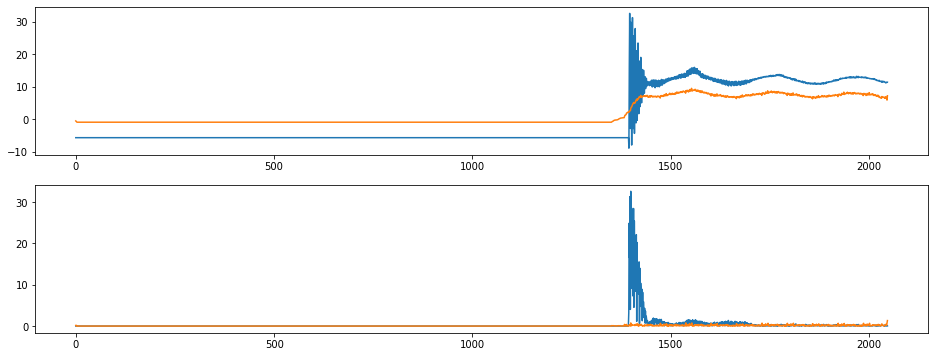

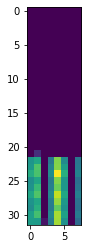

index:  57920
MAE:  4.838253422647104
n_bunches        780
bunch_index     1000
bunch_number     710
Name: 7442795, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6748/instability_data/06748_Inst_B1H_Q7_20180601_01h07m14s.h5


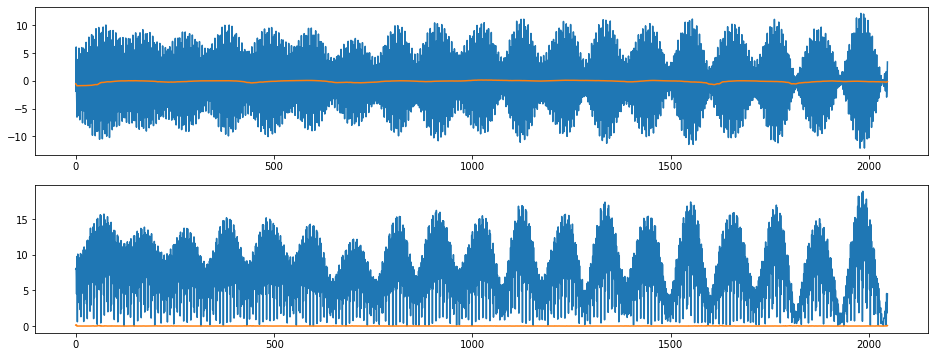

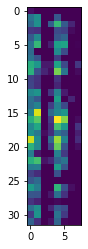

index:  237356
MAE:  4.7897367285197845
n_bunches       444
bunch_index     268
bunch_number    211
Name: 8762736, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6577/instability_data/06577_Inst_B1H_Q7_20180419_21h27m02s.h5


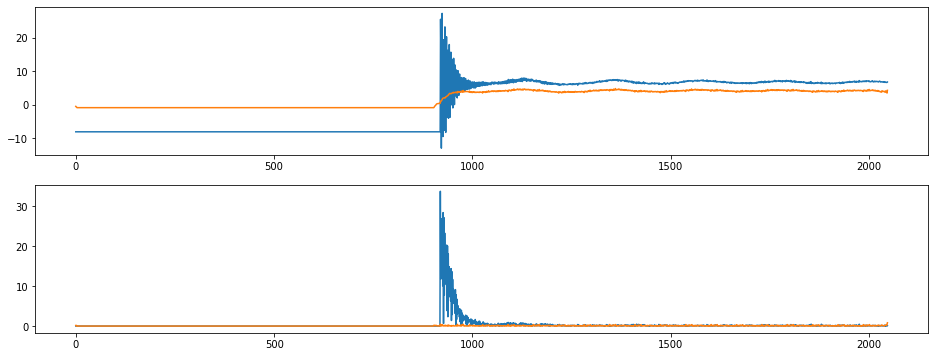

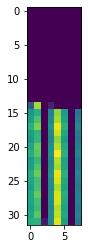

index:  93686
MAE:  4.785499682842784
n_bunches       1068
bunch_index     1447
bunch_number    1060
Name: 1524333, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_02h10m36s.h5


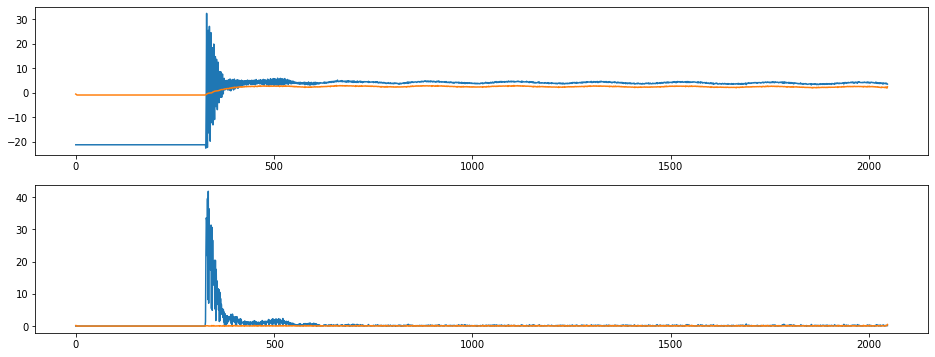

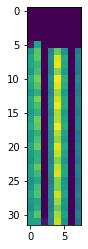

index:  54169
MAE:  4.783506330253877
n_bunches       2556
bunch_index     2118
bunch_number    1573
Name: 9436799, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7118/instability_data/07118_Inst_B1H_Q7_20180902_16h52m15s.h5


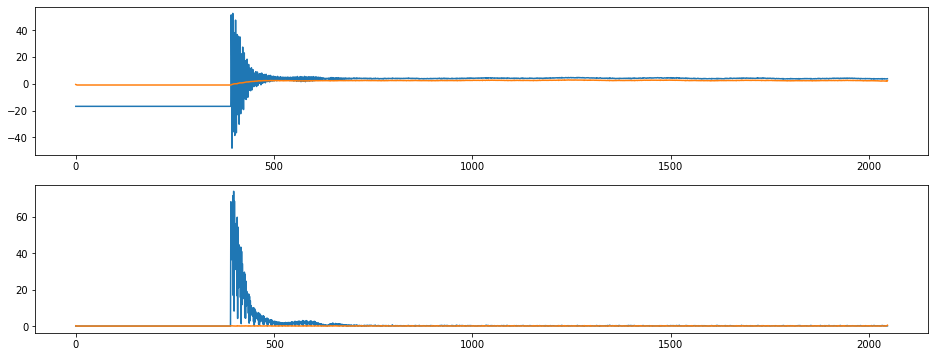

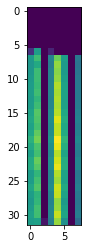

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()